In [2]:
#环境设置
import os
import re
import torch
import warnings
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
torch.backends.cudnn.benchmark=True
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import cv2
from skimage import io
from PIL import Image
import torchvision
from torch import nn
from torch import optim
import torchvision.utils as vutils
from torchvision import transforms
from torchvision import models as M
from torchvision import datasets as dest
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchinfo import summary

import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import pandas as pd
import datetime
from time import time
import gc

from sklearn.model_selection import train_test_split

manualSeed=1412
torch.manual_seed(manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda')

In [6]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2070 SUPER (UUID: GPU-ddd6b802-f52d-1fc7-5bf2-dc2c56c5fd41)


In [7]:
torch.cuda.memory_reserved()

0

In [8]:
torch.cuda.memory_allocated()

0

# 【案例】Kaggle医学影像识别

### 4.4 染色标准化入门：GAN、TransposeConv、DCGAN与cGAN

在染色标准化的三大方法之中，使用生成对抗网络GAN进行标准化是原理最复杂、运行成本最高、但效果往往最好的手段。生成对抗网络GAN是由Ian J. Goodfellow及其团队提出，除了这篇被评为“过去10年机器学习领域最有趣的想法”的原始论文[《生成对抗网络》](https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf)之外，Goodfellow等人还是被号称天书的著名深度学习教材花书的第一作者。无论是在花书还是在GAN的论文当中，Goodfellow本人的数学与技术能力都体现得淋漓尽致，但考虑到我们在案例中主要是以实践为核心，因此本次课程中将不会涉及到过于复杂的数学过程。

在生成对抗网络诞生之后数年之中，围绕着如何使用生成对抗网络进行染色标准化的研究层出不穷，今天这些研究中最为代表性的作品是Salehi等人在2020年完成的论文：

*[Salehi2020] P. Salehi, A. Chalechale, Pix2pix-based stain-to-stain translation: A solution for robust stain normalization in histopathology images analysis (2020), International Conference on Machine Vision and Image Processing*

这篇论文在经典对抗架构Pix2Pix的基础上做出了改进，创造出架构Stain-to-Stain Translation（STST），并成功实现了目前为止效果最优的染色标准化。如下图所示，a为原始染色载玻片，b为参考用的染色载玻片，c-g为使用不同方式实现染色标准化的生成图像。从颜色、轮廓等各个角度来看，STST的表现肉眼可见地超越了其他经典的染色标准化方法。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021PyTorchDL/HealthCareProject/17.png)

在本次我们的课程当中，我们将尝试复现上述论文中的STST架构，并尝试实现基于STST的染色标准化方法。STST架构是基于Pix2Pix2改进而来，而Pix2Pix是由如下基本架构组成：

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021PyTorchDL/HealthCareProject/18.2.png)

因此，为了掌握最终的STST架构，我们需要掌握如下基础知识：

1. 原始GAN的运行原理与代码<br>
2. 转置卷积TransposedConv与能够处理图像的DCGAN<br>
3. 自动编码器Autoencoders，经典Encoder-Decoder架构<br>
4. 深度卷积自动编码器（Convolutional Autoencoders）架构<br>
5. cGAN与PatchGAN架构<br>
6. Unet的损失函数、运行原理与代码<br>
7. STST架构基于Unet做出了怎样的改进<br>

在此之后，我们才能够将STST架构用于染色标准化。以上基础知识当中，你可以选择你不了解的部分进行学习，如果你已了解全部相关内容，可以直接从第7部分开始进行学习。

#### **4.4.1 GAN的基本原理与损失函数**

我们先来复习一下GAN的基本概况。假设现在存在一组从真实场景中收集的数据RealData，**生成对抗网络的关键使用场景之一就是借助真实数据RealData生成一组假数据FakeData，且这组假数据最好能够以假乱真**。有时候这组生成的假数据会用于替代真实数据或加入真实数据、用于训练神经网络，有时候这组生成的假数据就是我们最终想要获得的目标（例如，AI生成人脸的技术）。因此大部分时候，生成对抗网络的最终目标就是输出一组以假乱真的假数据。

如下图所示，一个生成对抗网络包含两个基础网络：生成器(generator，简写为G，也被称为生成网络)与判别器(discriminator，简写为D，也被称为判别网络)。其中，生成器用于生成新数据，其生成数据的基础往往是一组噪音或者随机数，而判别器用于判断生成的数据和真实数据哪个才是真的。生成器没有标签，是无监督网络；而判别器有标签，是有监督网络，其标签是“假与真”（0与1）。与普通二分类网络一样，判别器输出的是一类标签下的概率。在GAN官方论文中，我们规定判别器输出当前数据为真的概率（标签为1的概率），因此概率大于0.5时，判别器认为样本是真实数据，当概率小于0.5时，判别器认为样本是由生成器生成的假数据。

![](https://www.researchgate.net/publication/333831200/figure/fig5/AS:782113389412353@1563481771648/GAN-framework-in-which-the-generator-and-discriminator-are-learned-during-the-training.png)

**在训练过程中，生成器和判别器的目标是相矛盾的，并且这种矛盾可以体现在判别器的判断准确性上**。生成器的目标是生成尽量真实的数据（这也是我们对生成对抗网络的要求），最好能够以假乱真、让判别器判断不出来，因此**生成器的学习目标是让判别器上的判断准确性越来越低**；相反，判别器的目标是尽量判别出真伪，因此**判别器的学习目标是让自己的判断准确性越来越高**。

当生成器生成的数据越来越真时，判别器为维持住自己的准确性，就必须向判别能力越来越强的方向迭代。当判别器越来越强大时，生成器为了降低判别器的判断准确性，就必须生成越来越真的数据。在这个奇妙的关系中，判别器判断的准确性由GAN论文中定义的特殊交叉熵$V$来衡量，判别器与生成器共同影响交叉熵$V$，同时训练、相互内卷，对该交叉熵的控制是此消彼长的，这是真正的零和博弈。

- **特殊交叉熵$V$**

在生成器与判别器的内卷关系中，GAN的特殊交叉熵公式如下：

$$V(D,G)= \frac{1}{m}\sum_{i=1}^m [logD(x_i) + log(1-D(G(z_i))) ] $$

其中，字母$V$是原始GAN论文中指定用来表示该交叉熵的字母，对数log的底数为自然底数e，$m$表示共有$m$个样本，因此以上表达式是全部样本交叉的**均值**表达式。除此之外，$x_i$表示任意真实数据，$z_i$表示与真实数据相同结构的任意随机数据，$G(z_i)$表示在生成器中基于$z_i$生成的假数据，而$D(x_i)$表示判别器在真实数据$x_i$上判断出的结果，$D(G(z_i))$表示判别器在假数据$G(z_i)$上判断出的结果，其中$D(x_i)$与$D(G(z_i))$都是样本为“真”的概率，即标签为1的概率。

在原始论文中，这一交叉熵被认为是一种“损失”（Loss），但它有两个特殊之处：

1）不同于二分类交叉熵等常见的损失函数，**损失$V$上不存在最小值，反而存在最大值**。具体来看，$D(x_i)$与$D(G(z_i))$都是概率，因此这两个值的范围都在(0,1)之间。对于底数为$e$的对数函数来说，在定义域在(0,1)之间意味着函数的值域为($-\infty$,0)。因此理论上来说，损失$V$的值域也在($-\infty$,0)。

![](http://upload.wikimedia.org/wikipedia/commons/e/ec/Logx.svg)

2）**损失$V$在判别器的判别能力最强时达到最大值**，这就是说判别器判断得越准确时、损失反而越大，这违背我们对普通二分类网络中的损失函数的期待。但如果我们从判别器和生成器角度分别来看待公式$V$，则可以很快理解这一点。

> - **判别器的角度**

不难发现，在V的表达式中，两部分对数都与判别器D有关，而只有后半部分的对数与生成器G有关。因此我们可以按如下方式分割损失函数：

对判别器我们有：
$$Loss_D = \frac{1}{m}\sum_{i=1}^m [logD(x_i) + log(1-D(G(z_i))) ]$$

从判别器的角度来看，由于判别器希望自己尽量能够判断正确，而输出概率又是“数据为真”的概率，所以最佳情况就是所有的真实样本上的输出$D(x_i)$都无比接近1，而所有的假样本上的输出$D(G(z_i))$都无比接近0。因此对判别器来说，最佳损失值是：

$$\begin{aligned}
Loss_D &= \frac{1}{m}\sum_{i=1}^m [logD(x_i) + log(1-D(G(z_i))) ] \\
&= \frac{1}{m}\sum_{i=1}^m [log1 + log(1-0)]\\
&= 0
\end{aligned}$$

这说明**判别器希望以上损失$Loss_D$越大越好，且最大值理论上可达0，且判别器追求大$Loss_D$的本质是令$D(x)$接近1，令$D(G(z))$接近0**。不难发现，对判别器而言，$V$更像是一个存在上限的积极的指标（比如，准确率），即算法表现越好时，该指标的值越高。

> - **生成器的角度**

而从生成器的角度来看，生成器无法影响$D(x_i)$，只能影响$D(G(z_i))$，因此只有损失的后半段与生成器相关。因此对生成器我们有：

$$\begin{aligned}
Loss_G &= \frac{1}{m}\sum_{i=1}^m [常数 + log(1-D(G(z_i))] \\
去掉无关的常数部分：
&→ \frac{1}{m}\sum_{i=1}^mlog(1-D(G(z_i))
\end{aligned}$$

生成器的目标是令输出的数据越真越好，最好让判别器完全判断不出，因此生成器希望$D(G(z_i))$越接近1越好。因此对生成器来说，最佳损失是：

$$\begin{aligned}
Loss_G &= \frac{1}{m}\sum_{i=1}^m [log(1-D(G(z_i))] \\
&= \frac{1}{m}\sum_{i=1}^m [log(1-1)]\\
&= -\infty
\end{aligned}$$

这说明**生成器希望以上损失$Loss_G$越小越好，且最小值理论上可达负无穷，且生长期追求小$Loss_G$的本质是令$D(G(z))$接近1**。对生成器而言，$V$更像是一个损失，即算法表现越好，该指标的值越低。从整个生成对抗网络的角度来看，我们（使用者）的目标与生成器的目标相一致，因此对我们而言，$V$被定义为损失，它应该越低越好。

- 原始论文中的表示方法

在原始论文当中，该损失$V$被表示为如下形式：

$$\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}\ \ \ (x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}\ (z)}\big[log(1-D(G(z)))\big] $$ 

即先从判别器的角度令损失最大化，又从生成器的角度令损失最小化，即可让判别器和生成器在共享损失的情况下实现对抗。其中$E$表示期望，第一个期望$\mathbb{E}_{x\sim p_{data}\ \ \ (x)}\big[logD(x)\big]$是所有$x$都是真实数据时$logD(x)$的期望，第二个期望$\mathbb{E}_{z\sim p_{z}\  (z)}\big[log(1-D(G(z)))\big]$是所有数据都是生成数据时$log(1-D(G(z)))$的期望。**当真实数据、生成数据的样本点固定时，期望就等于均值**。因此论文中的这个式子与我们之前所写的、在损失前面乘以$\frac{1}{m}$在数学计算上并无区别。

如此，通过共享以上损失函数，生成器与判别器实现了在训练过程中互相对抗，$\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G)$的本质就是最小化$Loss_G$的同时最大化$Loss_D$。并且，在最开始训练时，由于生成器生成的数据与真实数据差异很大，因此$D(x_i)$应该接近1，$D(G(z_i))$应该接近0。理论上来说，只要训练顺利，最终$D(x_i)$和$D(G(z_i))$都应该非常接近0.5，但现实总不会那么地完美。在实际使用生成对抗网络时，生成器无法战胜判别器是很常见的情况，因此现在有各类的研究都在努力尝试提升生成器的生成水平，我们案例中所涉及的染色标准化的相关研究也是提升生成器性能的研究之一。

#### **4.4.2 详解基础GAN架构与反向传播代码**

- 定义判别器与生成器

![](https://www.researchgate.net/publication/333831200/figure/fig5/AS:782113389412353@1563481771648/GAN-framework-in-which-the-generator-and-discriminator-are-learned-during-the-training.png)

在最原始的GAN论文当中，生成器和判别器都是最普通的、以线性层构成的神经网络。如果你足够熟悉神经网络基础，那你一定会注意到生成对抗网络中的生成器、判别器两大网络都可以以非常简单的方式实现，例如我们可以假设生成器与判别器中都只有最为简单的2个线性层，其中激活函数都为LeakyReLU。为完成二分类，判别器的输出函数为sigmoid，生成器由于不需要完成分类任务、只需要输出结果，因此原则上不需要输出函数，但考虑到大部分时候我们所使用的都是图像数据、而图像数据是有界的数据，因此在生成器的最后我们会加上一个用于将数据归一化到固定范围的输出函数，大部分时候这个输出函数是Tanh。

同时，生成器生成的数据FakeData需要输入判别器，因此判别器的`in_features`参数必须与生成器的输出的`out_features`一致。对于判别器而言，除了输入生成器生成的FakeData之外，还需要接受真实数据RealData的输入，因此**一般我们默认FakeData的结构与RealData完全一致**。

In [638]:
class Discriminator(nn.Module):
    def __init__(self,in_features):
        """in_features : 真实数据的维度、同时也是生成的假数据的维度，对于普通神经网络而言就是特征数量"""
        super().__init__()
        self.disc = nn.Sequential(nn.Linear(in_features,128)
                                 #,nn.BatchNorm1d(128)
                                 ,nn.LeakyReLU(0.1) #由于生成对抗网络的损失非常容易梯度消失，因此使用LeakyReLU
                                 ,nn.Linear(128,1)
                                 ,nn.Sigmoid()
                                 )
    def forward(self,data):
        """输入的data可以是真实数据时，Disc输出dx。输入的data是gz时，Disc输出dgz"""
        return self.disc(data)

class Generator(nn.Module):
    def __init__(self,in_features,out_features):
        """
        in_features:生成器的in_features，一般输入z的维度z_dim，该值可自定义
        out_features:生成器的out_features，需要与真实数据的维度一致
        """
        super().__init__()
        self.gen = nn.Sequential(nn.Linear(in_features,256)
                                #,nn.BatchNorm1d(256)
                                ,nn.LeakyReLU(0.1)
                                ,nn.Linear(256,out_features)
                                ,nn.Tanh() #用于归一化数据
                                )
    def forward(self,z):
        gz = self.gen(z)
        return gz

In [639]:
#检测生成器、判别器能否顺利跑通
#假设真实数据结构为28*28*1 = 784
z = torch.ones((10,64))
gen = Generator(64,784)
gen(z).shape #生成数据

torch.Size([10, 784])

In [640]:
disc = Discriminator(784)
disc(gen(z)).shape #输出唯一值概率

torch.Size([10, 1])

- 定义其他关键要素

In [635]:
"""

在执行任意神经网络的反向传播之前，我们必须先定义好以下最为核心的元素：

1）数据 - 通常先导入为Datasets，再分批次变为dataloader
2）神经网络 - 对生成对抗网络来说就是生成器和判别器
3）损失函数
4）优化器
5）各类超参数和硬件设置，包括epochs的数量，学习率、gpu设备等等

"""

batch_size = 32
lr = 3e-4
num_epochs = 50
realdata_dim = 28*28*1 #784
z_dim = 64 #64,128,256

#设备设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#真实数据 - 以最为简单的MNIST数据为例
transform = transforms.Compose([transforms.ToTensor()
                                #,transforms.Normalize((0.1307),(0.3081))])
                                ,transforms.Normalize((0.5),(0.5))])
dataset = dest.MNIST(root=r"E:\02_2022DL\HealthCareProject",transform=transform,download=True)
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

#设置一组固定的噪音数据，用于在训练中不断验证生成器的结果
#作为需要输入生成器的噪音，这组数据的样本量应与batch_size一致，维度可自由选择
#注意区别于训练中不断放入G的噪音z
fixed_noise = torch.randn((batch_size,z_dim)).to(device)

#实例化判别器与生成器
gen = Generator(in_features=z_dim,out_features=realdata_dim).to(device)
disc = Discriminator(in_features=realdata_dim).to(device)

#定义判别器与生成器所使用的优化算法
optim_disc = optim.Adam(disc.parameters(),lr=lr,betas=(0.9,0.999))
optim_gen = optim.Adam(gen.parameters(),lr=lr,betas=(0.9,0.999))

#定义损失函数
criterion = nn.BCELoss(reduction="mean") #默认生成均值，也可以特定标明生成均值

In [637]:
len(dataloader) #共有1875个batch

1875

In [636]:
#检查normalize之后图像的范围
for x,_ in dataloader:
    print(x.min())
    print(x.max())
    break

tensor(-1.)
tensor(1.)


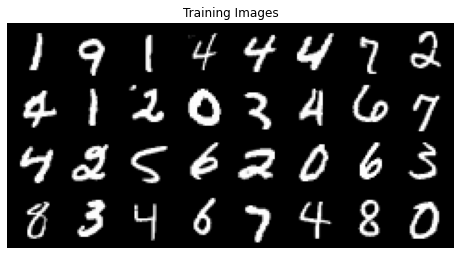

In [641]:
#对当前数据集绘图
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)));

- 判别器与生成器上的反向传播

现在，如何让这两个网络共享损失、且同时迭代呢？之前我们提到过，$\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G)$的本质就是最小化$Loss_G$的同时最大化$Loss_D$，因此在代码中我们需要从两个网络的角度分别构建损失函数、并同时迭代。

同时，无论使用怎样的深度学习框架，我们最好使用框架原始定义好的损失函数类来实现当前损失。对PyTorch框架来说，我们往往使用criterion表示损失函数的类，并直接对criterion所生成的损失loss进行反向传播，因此我们最好选择PyTorch已经定义好的criterion来表示实际迭代的损失。

**非常神奇的是，在GAN的实际反向传播过程中，我们真实迭代的损失函数公式与$Loss_G$和$Loss_D$都不同。为描述清晰，之后我们将使用$error$来表示代码实现过程中所使用的损失函数。**

In [643]:
#损失函数\优化算法\迭代网络
#net = MyNet()
#criterion = BCELoss()
#optim = Adam()

#具体迭代
#loss = criterion(p,ytrue)
#loss.backward()
#optim.step()
#net.zero_grad()

- **判别器的损失与反向传播**

对判别器，我们最终实际进行反向传播的损失表达式为：

$$error_D = -\frac{1}{m}\sum_{i=1}^m[log(D(x_i)) + log(1-D(G(z_i)))]$$

不难发现$error_D$其实等同于$-Loss_D$。作为一个二分类网络，判别器的职责是让$Loss_D$越来越大，这一职责与我们对分类网络的一般期待相违背（因为分类网络们总是令损失越来越小的），且PyTorch中我们也只能令损失函数最小，因此我们将$Loss_D$变换为了$-Loss_D$，将最大化$Loss_D$的问题转变为了最小化$-Loss_D$的问题，因此实际代码实现过程中所使用的损失$error_D$就是$-Loss_D$了。

在此基础上，基于$error_D$实现反向传播的具体代码如下所示：

In [648]:
torch.ones_like(torch.tensor([3,6,7]))

tensor([1, 1, 1])

In [ ]:
#非完整代码，请勿运行

for epoch in range(num_epochs):
    for batch_idx, (x,_) in enumerate(dataloader):
        
        x = x.view(-1,784).to(device)
        batch_size = x.shape[0]
        
        ############################
        # (1) 判别器的反向传播：最小化 -[logD(x) + log(1 - D(G(z)))]
        ############################

        #-logdx
        #生成需要输入criterion的真实标签1与预测概率dx【Q2】
        dx = disc(x).view(-1)
        #计算所有真实数据的损失均值
        loss_real = criterion(dx,torch.ones_like(dx))
        loss_real.backward()
        D_x = dx.mean().item()

        #-log(1-dgz)
        #生成需要输入criterion的真实标签0与预测概率dgz
        #输入噪音，一般默认生成的假数据的样本量与真实数据一致
        #因此噪音z的样本量也必须与真实数据样本量一致，但噪音的维度可自由调整
        noise = torch.randn((batch_size,z_dim)).to(device)
        gz = gen(noise)
        dgz1 = disc(gz.detach())
        #计算所有假数据上的损失均值
        loss_fake = criterion(dgz1,torch.zeros_like(dgz1))
        loss_fake.backward()
        D_G_z1 = dgz1.mean().item()

        #计算errorD
        errorD = (loss_real + loss_fake)/2 #对均值之和再求均值，得到真假数据的损失均值【Q3】
        #errorD.backward() #直接对errorD反向传播，也可分别对loss_real，loss_fake执行反向传播
        optim_disc.step() #更新判别器上的权重
        disc.zero_grad() #清零判别器迭代后的梯度

- **Q1：为何选择BCELoss？**

先来看$-Loss_D$，作为二分类网络的损失，它不禁让我们想起二分类有监督网络最常用的损失函数：二分类交叉熵`BCELoss`。观察$-Loss_D$，我们会发现它与二分类交叉熵非常相似：

> - **-Loss_D**（均值）<br><br>
$$-\frac{1}{m}\sum_{i=1}^m[logD(x_i) + log(1-D(G(z_i)))] $$

> - **二分类交叉熵**（均值）<br><br>
$$-\frac{1}{m}\sum_{i=1}^m[(y_ilog(p_i) + (1-y_i)log(1-pi))]$$

不难发现，$-Loss_D$只是在二分类交叉熵损失的基础上去掉了和真实标签$y_i$相关的部分，只要令真实标签$y_i$为0就可以表示log(1-pi)部分，只要令真实标签为1就可以表示log(pi)部分，因此`BCELoss`可以分别表示$-Loss_D$的前半段与后半段。

- **Q2：如何使用BCELoss表示-lossD？**

基于PyTorch中的二分类交叉熵损失`BCELoss`，如果我们令真实标签为1（真实数据），并让二分类交叉熵中的$p_i$等于$D(x_i)$，则可以得到只与真实数据有关的损失$loss_{real}$：

> - **`criterion(D(x),y_true=1)`**<br><br>
$$loss_{real} = -\frac{1}{m}\sum_{i=1}^m log(D(x_i))$$

如果我们令真实标签为0（生成数据/假数据），并让二分类交叉熵中的$p_i$等于$D(G(z_i))$，则可以得到只与假数据有关的损失$loss_{fake}$：

> - **`criterion(D(G(z)),y_true=0)`**<br><br>
$$loss_{fake} = -\frac{1}{m}\sum_{i=1}^m log(1-D(G(z_i))$$

注意，这两个损失都是从`BCELoss`计算而来，因此只能够求解最小值。基于以上两个损失，我们很容易得到一个<font color="red">**错误结论**</font>，即：

$$\begin{aligned}
&\ \ \ \ \ loss_{real} + loss_{fake} \\ \\
&= -\frac{1}{m}\sum_{i=1}^mlog(D(x_i)) -\frac{1}{m}\sum_{i=1}^mlog(1-D(G(z_i)) \\ \\
&= -\frac{1}{m}\sum_{i=1}^m[log(D(x_i)) + log(1-D(G(z_i)))] \\ \\
&= - Loss_D
\end{aligned}
$$

这里其实存在一个陷阱：对$error_D$而言，样本总量m是真实数据数量与假数据数量之和，而对于$loss_{real}$而言m只是真实数据数量，对于$loss_{fake}$而言m只是假数据数量，因此$loss_{real} + loss_{fake} = 2 *error_D$。我们具体来看：

- **Q3: 为什么需要对$loss_{real} + loss_{fake}$除以2？**

我们想要求解的是整个数据集上损失的均值，因此该均值为：

$$errorD = \frac{TotalLossD}{真实数据数量 + 假数据数量}$$

**在生成对抗网络中，我们一般设定生成器生成的假数据的数量与真实数据数量一致**，因此整个数据集上的均值可以被表示为：

$$\frac{TotalLossD}{真实数据数量 * 2}$$

现在我们有的分别是真实数据损失的均值和假数据损失的均值，相当于有：

$$loss_{real} = \frac{Total\_loss\_real}{真实数据数量},\ \  loss_{fake} = \frac{Total\_loss\_fake}{假数据数量}$$

当我们让以上两个均值相加时有：

$$\begin{aligned}
&\ \ \ \ \frac{Total\_loss\_real}{真实数据数量} + \frac{Total\_loss\_fake}{假数据数量} \\ \\
&= \frac{Total\_loss\_real}{真实数据数量} + \frac{Total\_loss\_fake}{真实数据数量} \\ \\
&= \frac{Total\_loss\_real + Total\_loss\_fake}{真实数据数量} \\ \\
&= \frac{TotalLossD}{真实数据数量}
\end{aligned}$$

很明显，这一式子与我们想要的整个数据集的均值表达式相比起来，只在分母上少了一个2。因此我们将两个均值相加后除以2，即可得到整个数据集上损失的均值。

因此，最小化$-Loss_D$就等于最小化$\frac{1}{2}(loss_{real} + loss_{fake})$。原本$Loss_D$的值域是($-\infty$,0)，当取负后$-Loss_D$的值域即变为(0,$\infty$)，因此$loss_{real} + loss_{fake}$理论上的最小值也是0。因此，在将论文中的$Loss_D$转变为代码的过程中，我们执行了如下流程：
> 1. 将最大化$Loss_D$转变为最小化$-Loss_D$<br><br>
> 2. 使用二分类交叉熵损失`BCELoss`分别表示$-Loss_D$的两部分<br><br>
> 3. 将两部分损失加和，实现使用`BCELoss`表示完整的$-Loss_D$。

- **生成器的损失与反向传播**

对生成器，我们最终实际进行反向传播的损失表达式为：

$$error_G = -\frac{1}{m}\sum_{i=1}^m log(D(G(z_i)))$$

具体代码为：

In [ ]:
#非完整代码，请勿运行

img_list = []
G_losses = []
D_real_loss = []
D_fake_loss = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for batch_idx, (x,_) in enumerate(dataloader):

        x = x.view(-1,784).to(device)
        batch_size = x.shape[0]
        
        ############################
        # (1) 判别器的反向传播：最小化 -[logD(x) + log(1 - D(G(z)))]
        ############################

        #-logdx
        dx = disc(x).view(-1)
        loss_real = criterion(dx,torch.ones_like(dx))
        loss_real.backward()
        D_x = dx.mean().item()

        #-log(1-dgz)
        noise = torch.randn((batch_size,z_dim)).to(device)
        gz = gen(noise)
        dgz1 = disc(gz.detach()) #需要使用detach来阻止gz进入D的计算图
        loss_fake = criterion(dgz1,torch.zeros_like(dgz1))
        loss_fake.backward()
        D_G_z1 = dgz1.mean().item()

        #计算errorD
        errorD = (loss_real + loss_fake)/2
        optim_disc.step()
        disc.zero_grad()
    
        ############################
        # (2) 生成器的反向传播：最小化 -log(D(G(z)))
        ############################
        #生成需要输入criterion的真实标签1与预测概率gdz
        #注意，由于在此时判别器上的权重已经被更新过了，所以dgz的值会变化，需要重新生成
        dgz2 = disc(gz)
        #计算errorG
        errorG = criterion(dgz2,torch.ones_like(dgz2))
        errorG.backward() #反向传播
        optim_gen.step() #更新生成器上的权重
        gen.zero_grad() #清零生成器更新后梯度
        D_G_z2 = dgz2.mean().item()
        
        if batch_idx % 500 == 0 or batch_idx == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f
                   \tD(G(z)): %.4f / %.4f' % (epoch+1, num_epochs, batch_idx,
                   len(dataloader),errorD.item(), errorG.item(), D_x, D_G_z1, D_G_z2))

        #保存errorG和errorD，以便后续绘图用
        G_losses.append(errorG.item())
        D_real_loss.append(loss_real.item())
        D_fake_loss.append(loss_fake.item())
        D_losses.append(errorD.item())

        #将固定噪音fixed_noise输入生成器，查看输出的结果变化
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and
           (batch_idx == len(dataloader)-1)):
           
            with torch.no_grad():
                fake = gen(fixed_noise).cpu().detach()
            print("fake data saved")
            img_list.append(fake.view(-1,1,28,28))

        iters += 1

不难发现，我们在生成器实际迭代时所使用的损失函数是`criterion(dgz,y_true=1)`，也就是说实际迭代的errorG公式为：

> - **`criterion(D(G(z)),y_true=1)`**<br><br>
> $$error_G = -\frac{1}{m}\sum_{i=1}^m logD(G(z_i))$$

为什么不使用原始论文中所定义的生成器损失$Loss_G$呢？

> - **Loss_G**（均值）<br><br>
$$Loss_G = \frac{1}{m}\sum_{i=1}^m log(1-D(G(z_i)))$$

在判别器中我们使用`BCELoss`表示来表示损失$Loss_D$，因此我们或许也可以使用`BCELoss`以相似的方式来表示生成器的损失$Loss_G$，然而在实践中我们却使用了完全不同的另一个式子，主要有两个理由：

1. **根据GAN原始论文论证，$Loss_G$的梯度函数是饱和梯度函数，不利于迭代**。
> 具体地来说，如果按照$D(G(z_i))$为自变量对$Loss_G$求导，可以得到导函数$\frac{-1}{1-D(G(z_i))}$。如下图所示，横坐标为$D(G(z_i))$的值，纵坐标为导函数、也就是负梯度的值。我们都知道，损失减小的方向是梯度的反方向，因此负梯度值越大，损失减小得就相对越快。刚开始迭代时，生成器输出的结果一定很糟糕、因此$D(G(z_i))$必然很小，正是需要大步迭代的时候，但此时$\frac{-1}{1-D(G(z_i))}$上的负梯度却很小；当迭代到后期$D(G(z_i))$值相应变大，应该控制迭代速率、避免跳过局部最优值的时候，$\frac{-1}{1-D(G(z_i))}$上的负梯度却变得很大。<br><br>
> 在GAN原始论文中，导函数$\frac{-1}{1-D(G(z_i))}$上的梯度被称为是“饱和梯度”（saturating gradient）。这种先小后大的梯度变化违背我们对于梯度值的期待，可能让整体迭代过程变得很不稳定。因此为了能够更快地迭代，我们需要更换$Loss_G$的表达式。

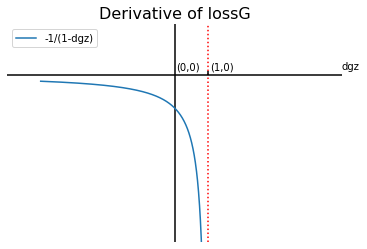

In [35]:
dgz1 = np.linspace(0.001,5,num=1000,endpoint=False)
dgz2 = np.linspace(-4,1,num=1000,endpoint=False)
d1 = -1/dgz1
d2 = -1/(1-dgz2)
plt.plot(dgz2,d2,label="-1/(1-dgz)")
#plt.plot(dgz1,d1,label="non-saturating")
plt.title("Derivative of lossG",fontsize=16)
plt.xlim((-5,5))
plt.ylim((-5,1.5))
plt.vlines(1,-5,1.5,linestyle="dotted",colors="red")
plt.vlines(1,0,0.1,colors="k")
plt.vlines(0,-5,1.5,colors="k")
plt.hlines(0,-5,5,colors="k")
plt.axis("off")
plt.text(5,0.15,"dgz")
plt.text(0.05,0.15,"(0,0)")
plt.text(1.05,0.15,"(1,0)")
plt.legend(loc=2);

2. **论文中要求我们向减小$Loss_G$的方向迭代，但我们无法使用`BCELoss`直接表示$Loss_G$，更无法直接对$Loss_G$进行最小化操作**。
> 具体地来说，在使用`BCELoss`表示$-Loss_D$的过程中，我们曾计算过真实标签$y_i$为0，预测概率$p_i = D(G(z_i))$的$loss_{fake}$：
> - **`criterion(D(G(z)),y_true=0)`**<br><br>
> $$loss_{fake} = -\frac{1}{m}\sum_{i=1}^m log(1-D(G(z_i))$$
> - **Loss_G**（均值）<br><br>
> $$Loss_G = \frac{1}{m}\sum_{i=1}^m log(1-D(G(z_i)))$$<br>
对比$loss_{fake}$与生成器的损失$Loss_G$，很明显$loss_{fake} = - Loss_G$。在GAN训练过程当中，我们要追求$Loss_G$的最小值，所以在$- Loss_G$上要追求的就是最大值，然而对于`BCELoss`我们只能求解最小值，因此直接使用二分类交叉熵表示$Loss_G$的方法不适用于生成器。

基于以上两个理由，我们需要修改$Loss_G$的表达式。已知$D(G(z))$的范围是(0,1)，因此我们可以绘制出$Loss_G$在定义域(0,1)上的图像：

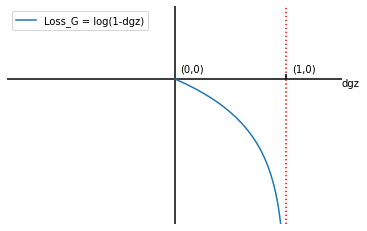

In [16]:
dgz = np.linspace(0.001,0.999,num=1000,endpoint=False)
y2 = np.log((1-dgz))
plt.plot(dgz,y2,label="Loss_G = log(1-dgz)")
plt.xlim((-1.5,1.5))
plt.ylim((-3,1.5))
plt.vlines(1,-3,1.5,linestyle="dotted",colors="red")
plt.vlines(1,0,0.1,colors="k")
plt.vlines(0,-3,1.5,colors="k")
plt.hlines(0,-2,2,colors="k")
plt.axis("off")
plt.text(0.05,0.15,"(0,0)")
plt.text(1.05,0.15,"(1,0)")
plt.text(1.5,-0.15,"dgz")
plt.legend(loc=2);

不难发现，令函数$Loss_G$越来越小的本质是让$D(G(z))$越来越接近1，因此**在实践当中，只要我们能维持让$D(G(z))$越来越接近1这一本质，就可以将损失更换为更适合于实践的方式**。让我们对比一下原本的$Loss_G$与实际反向传播中使用的$error_G$：

$$error_G = -\frac{1}{m}\sum_{i=1}^m log(D(G(z_i)))$$

$$Loss_G = \frac{1}{m}\sum_{i=1}^m log(1-D(G(z_i))$$

很明显，$error_G$这一函数可以通过将$Loss_G$的水平翻转后，再向右移动1个单位、再垂直翻转来得到。我们也可以基于定义域(0,1)绘制出$error_G$的函数图像：

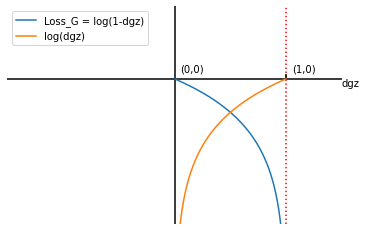

In [17]:
dgz = np.linspace(0.001,0.999,num=1000,endpoint=False)
y1 = np.log(dgz) #令该损失最小化的本质是令gz靠近0
y2 = np.log((1-dgz))
plt.plot(dgz,y2,label="Loss_G = log(1-dgz)")
plt.plot(dgz,y1,label="log(dgz)")
plt.xlim((-1.5,1.5))
plt.ylim((-3,1.5))
plt.vlines(1,-3,1.5,linestyle="dotted",colors="red")
plt.vlines(1,0,0.1,colors="k")
plt.vlines(0,-3,1.5,colors="k")
plt.hlines(0,-2,2,colors="k")
plt.axis("off")
plt.text(0.05,0.15,"(0,0)")
plt.text(1.05,0.15,"(1,0)")
plt.text(1.5,-0.15,"dgz")
plt.legend(loc=2);

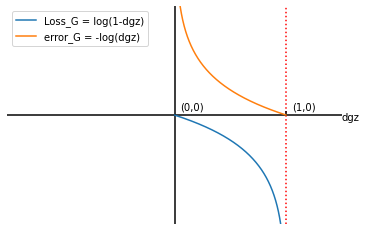

In [18]:
dgz = np.linspace(0.001,0.999,num=1000,endpoint=False)
y1 = -np.log(dgz) #令该损失最小化的本质是令gz靠近0
y2 = np.log((1-dgz))
plt.plot(dgz,y2,label="Loss_G = log(1-dgz)")
plt.plot(dgz,y1,label="error_G = -log(dgz)")
plt.xlim((-1.5,1.5))
plt.ylim((-3,3))
plt.vlines(1,-3,3,linestyle="dotted",colors="red")
plt.vlines(1,0,0.1,colors="k")
plt.vlines(0,-3,3,colors="k")
plt.hlines(0,-2,2,colors="k")
plt.axis("off")
plt.text(0.05,0.15,"(0,0)")
plt.text(1.05,0.15,"(1,0)")
plt.text(1.5,-0.15,"dgz")
plt.legend(loc=2);

不难发现，当$D(G(z_i))$逐渐接近1时，原本的$Loss_G$是越来越小的，而转换后的$error_G$也是越来越小的，因此**原本的求解$Loss_G$的最小值的问题等价于求解$error_G$的最小值的问题，他们的本质都是令$D(G(z_i))$越来越接近1**。因此我们最终进行反向传播的损失就由论文中的$Loss_G$转变为了$error_G$：

$$error_G = -\frac{1}{m}\sum_{i=1}^m log(D(G(z_i)))$$

不难发现，在将论文中的$Loss_G$转变为代码的过程中，我们执行了如下流程：
> 1. 由于梯度饱和问题、以及$Loss_G$难以用`BCELoss`表示的问题，将最小化$Loss_G$的问题转化为了最小化$error_G$的问题<br><br>
> 3. 使用`BCELoss`表示$error_G$，并在$error_G$上执行反向传播<br>

接下来我们可以开始正式对模型进行训练了，直接运行刚才呈现过的循环代码，并将损失等值保存下来绘制图像：

In [626]:
#在训练完毕之后，如果需要继续训练，则千万要避免运行这一个cell
img_list = [] #我们在训练过程中不断让fixed_noise被输入生成器，并不断生成的假数据的列表
G_losses = []
D_real_loss = []
D_fake_loss = []
D_losses = []
iters = 0

In [615]:
for epoch in range(num_epochs):
    for batch_idx, (x,_) in enumerate(dataloader):

        x = x.view(-1,784).to(device)
        batch_size = x.shape[0]
        
        ############################
        # (1) 判别器的反向传播：最小化 -[logD(x) + log(1 - D(G(z)))]
        ############################

        #-logdx
        dx = disc(x).view(-1)
        loss_real = criterion(dx,torch.ones_like(dx))
        loss_real.backward()
        D_x = dx.mean().item()

        #-log(1-dgz)
        noise = torch.randn((batch_size,z_dim)).to(device)
        gz = gen(noise)
        dgz1 = disc(gz.detach())
        loss_fake = criterion(dgz1,torch.zeros_like(dgz1))
        loss_fake.backward()
        D_G_z1 = dgz1.mean().item()

        #计算errorD
        errorD = (loss_real + loss_fake)/2
        optim_disc.step()
        disc.zero_grad()
    
        ############################
        # (2) 生成器的反向传播：最小化 -log(D(G(z)))
        ############################
        #生成需要输入criterion的真实标签1与预测概率gdz
        #注意，由于在此时判别器上的权重已经被更新过了，所以dgz的值会变化，需要重新生成
        dgz2 = disc(gz)
        #计算errorG
        errorG = criterion(dgz2,torch.ones_like(dgz2))
        errorG.backward() #反向传播
        optim_gen.step() #更新生成器上的权重
        gen.zero_grad() #清零生成器更新后梯度
        D_G_z2 = dgz2.mean().item()
        
        #监控训练进度
        if batch_idx % 500 == 0 or batch_idx == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' %
                  (epoch+1, num_epochs, batch_idx, len(dataloader),errorD.item(), errorG.item(), D_x, D_G_z1, D_G_z2))

        #保存errorG和errorD，以便后续绘图用
        G_losses.append(errorG.item())
        D_real_loss.append(loss_real.item())
        D_fake_loss.append(loss_fake.item())
        D_losses.append(errorD.item())

        #将固定噪音fixed_noise输入生成器，查看输出的结果变化
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).cpu().detach()
            print("fake data saved")
            img_list.append(fake.view(-1,1,28,28))

        iters += 1

[1/50][0/1875]	Loss_D: 0.7093	Loss_G: 0.5060	D(x): 0.6589	D(G(z)): 0.6125 / 0.6102
fake data saved
[1/50][500/1875]	Loss_D: 0.6854	Loss_G: 0.5023	D(x): 0.6882	D(G(z)): 0.6146 / 0.6113
fake data saved
[1/50][1000/1875]	Loss_D: 0.7040	Loss_G: 0.5082	D(x): 0.6650	D(G(z)): 0.6111 / 0.6091
fake data saved
[1/50][1500/1875]	Loss_D: 0.7924	Loss_G: 0.4195	D(x): 0.6652	D(G(z)): 0.6725 / 0.6642
fake data saved
[2/50][0/1875]	Loss_D: 0.7101	Loss_G: 0.4920	D(x): 0.6866	D(G(z)): 0.6273 / 0.6187
fake data saved
[2/50][500/1875]	Loss_D: 0.7079	Loss_G: 0.4991	D(x): 0.6672	D(G(z)): 0.6165 / 0.6142
fake data saved
[2/50][1000/1875]	Loss_D: 0.7195	Loss_G: 0.4983	D(x): 0.6505	D(G(z)): 0.6170 / 0.6145
fake data saved
[2/50][1500/1875]	Loss_D: 0.7056	Loss_G: 0.5056	D(x): 0.6649	D(G(z)): 0.6139 / 0.6094
[3/50][0/1875]	Loss_D: 0.7104	Loss_G: 0.4895	D(x): 0.6792	D(G(z)): 0.6260 / 0.6196
fake data saved
[3/50][500/1875]	Loss_D: 0.7074	Loss_G: 0.4834	D(x): 0.6940	D(G(z)): 0.6320 / 0.6232
fake data saved
[3/50][1

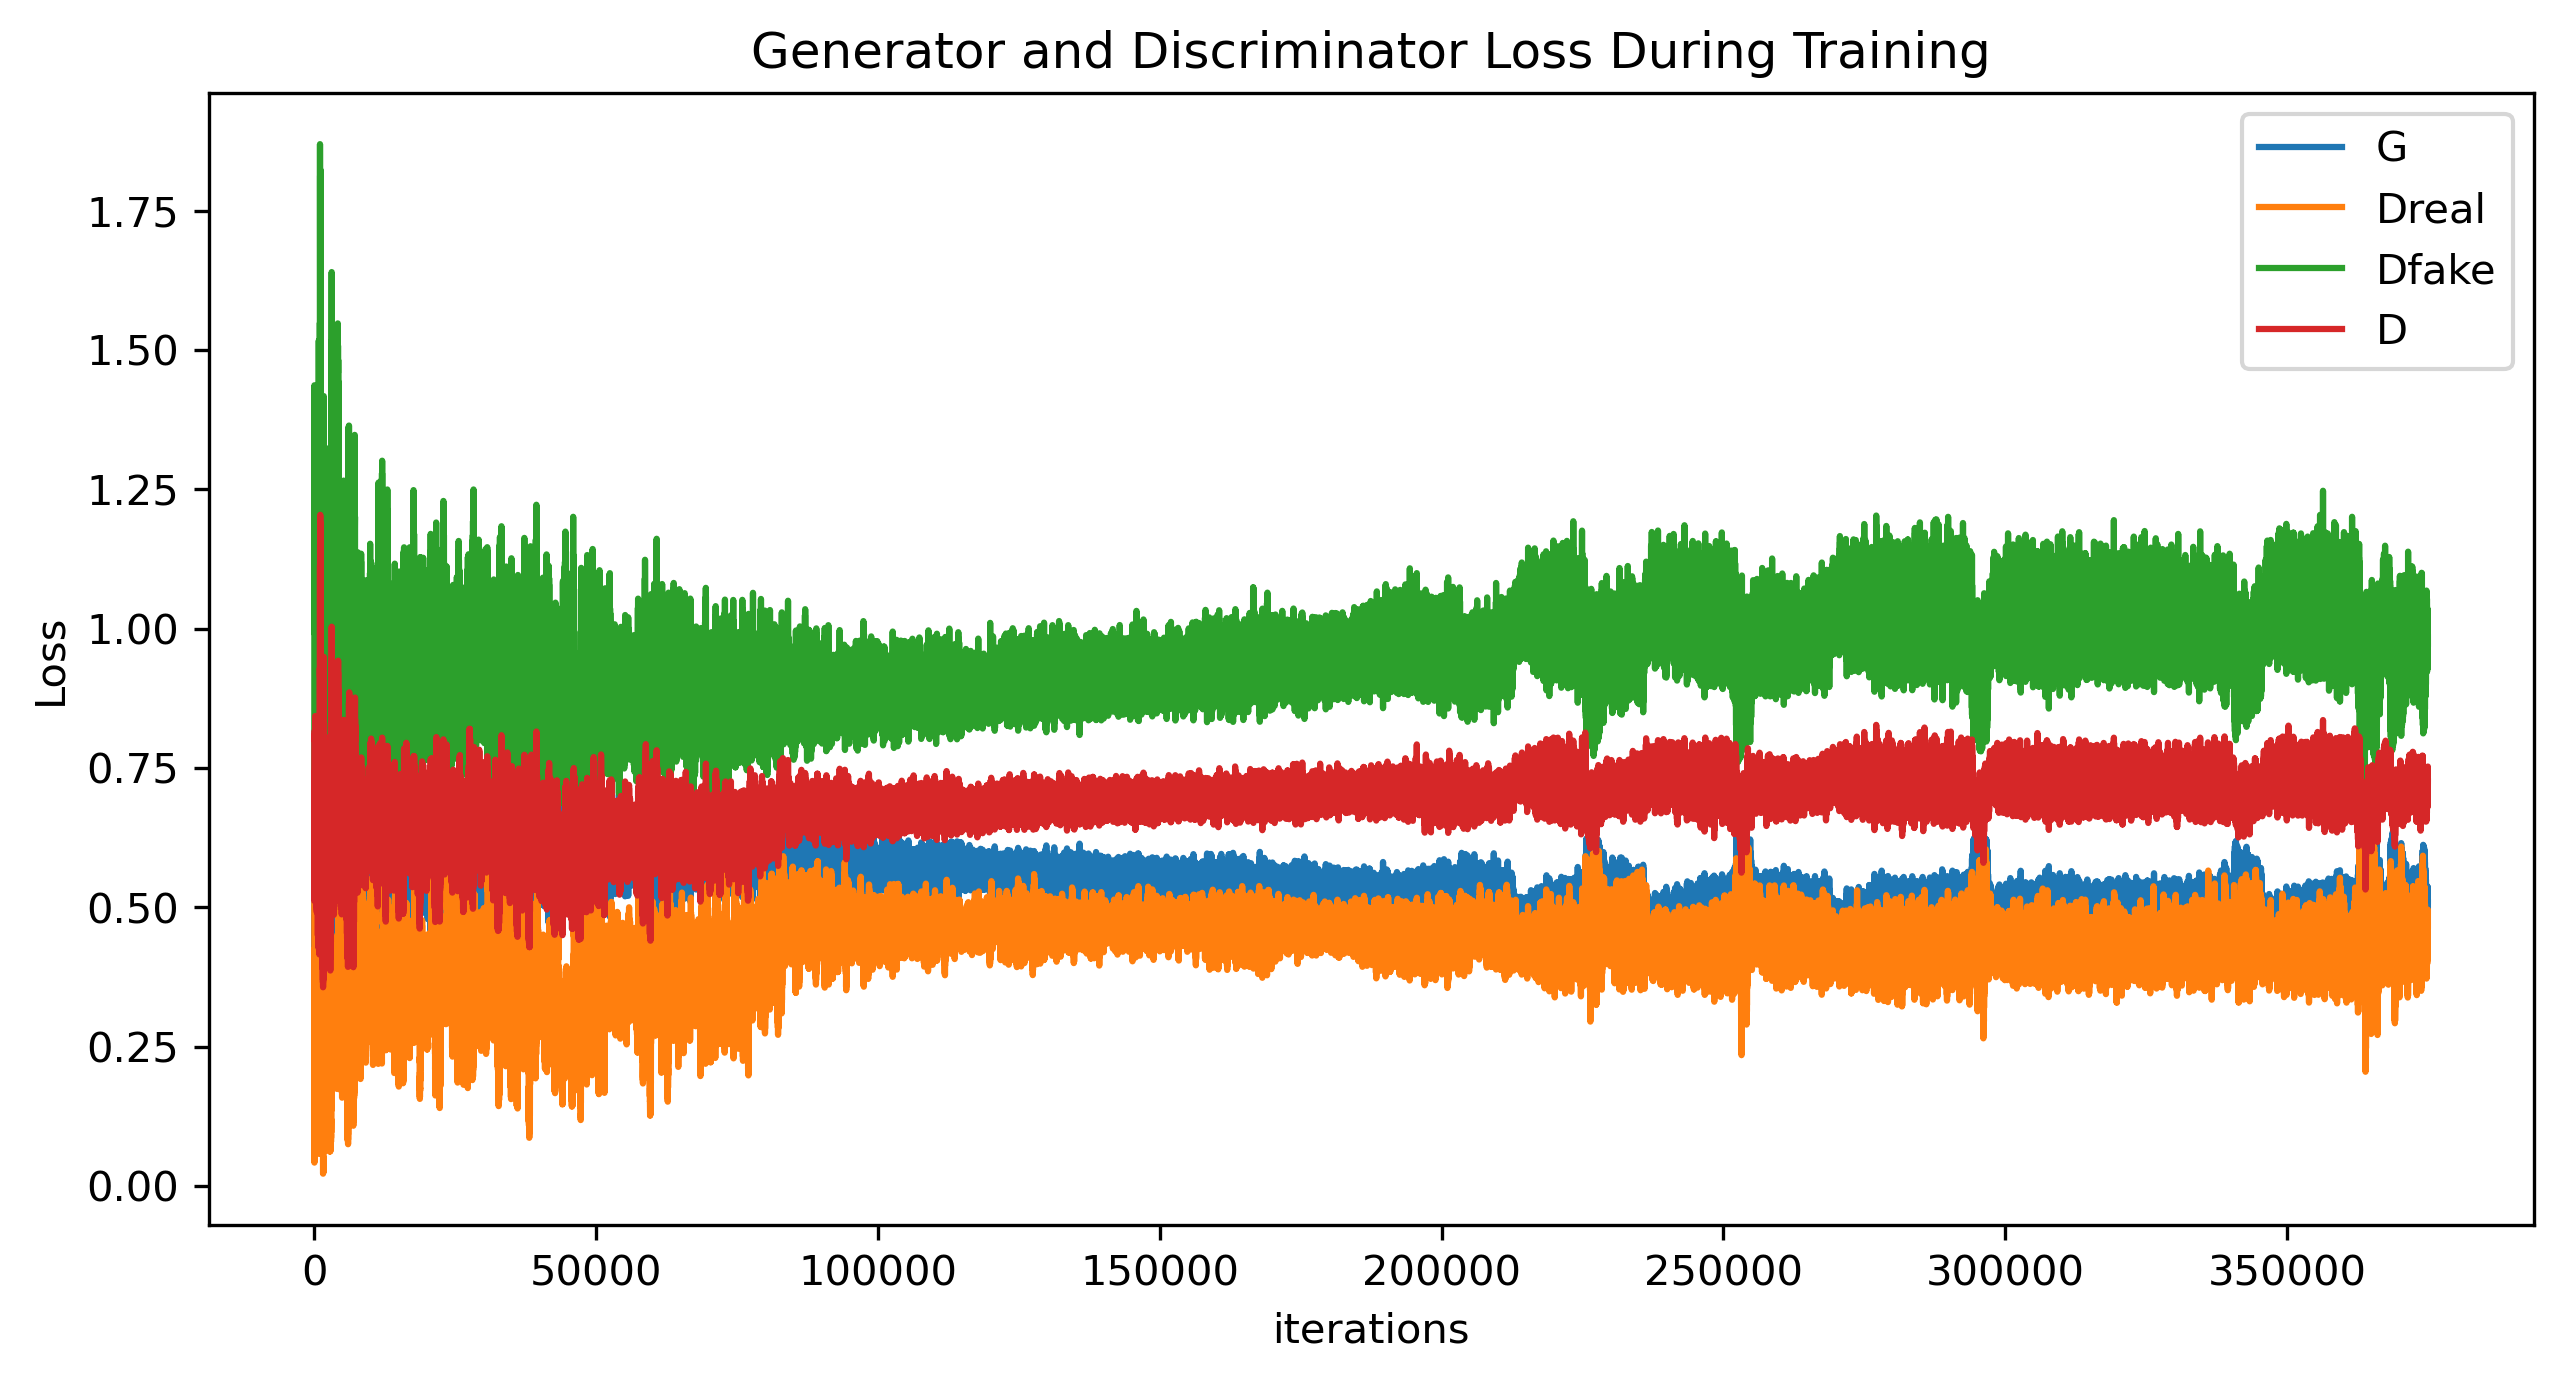

In [619]:
plt.figure(figsize=(10,5),dpi=300)
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_real_loss,label="Dreal")
plt.plot(D_fake_loss,label="Dfake")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

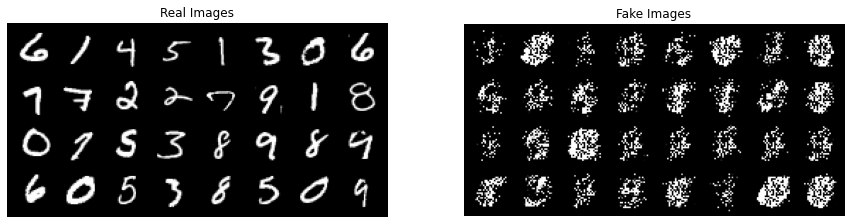

In [621]:
#绘制原始图像与生成图像
real_batch = next(iter(dataloader))

#原始图像中抽取一个batch
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:batch_size], padding=5, normalize=True).cpu(),(1,2,0)))

#绘制保存的最后一组生成图像
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1].reshape(-1,1,28,28)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

很明显，我们的生成对抗网络展现出2个特性：首先，生成器所生成的假数据在肉眼看来还远远不够真，其次，判别器在真假数据的判断上已经无能为力了。

$$\begin{aligned}
Loss_D &= loss_{real} + loss_{fake} \\ \\
&= -\frac{1}{m}\sum_{i=1}^mlog(D(x_i)) -\frac{1}{m}\sum_{i=1}^mlog(1-D(G(z_i))
\end{aligned}
$$

结合损失的图像与$Loss_D$的公式，我们可以发现，在迭代刚开始的时候，$loss_{real}$非常接近于0，这说明$D(x)$的值在最初应该非常接近于1，但$loss_{fake}$在刚开始时就接近于1，按照$-log(1-D(G(z_i)) = 1$来求解，可得出$D(G(z))$最开始就非常接近0.5。这说明，判别器虽然能够很好地判断出真实数据，但对假数据却完全无能为力，模型严重缺乏判断力，根本无法给生成器提供有效的刺激和信息。在训练的过程当中，很明显，$real_loss$略有升高，$fake_loss$略有降低，且从后续迭代时打印的结果来看，$D(x)$的值已经与$D(G(z))$的值就非常相似，这说明判别器在整个网络中的作用已经可以忽略不计了。也因此，在缺乏判别器刺激的情况下，生成器迭代的速度自然也相当缓慢。在迭代次数超过35w次的情况下，生成器的输出结果依然不尽如人意，可以考虑不再继续迭代，转而调整架构本身。

生成对抗网络GAN在整个深度学习业界是训练难度地狱级的模型，GAN架构对超参数异常敏感，且有时会输出令人难以理解的结果（例如我们上面的判别器，只判断真数据、对假数据一律给接近0.5的概率，且随着迭代连真数据也只给接近0.5的概率了），同时还需要很长的训练时间与众多运算资源，因此要想训练一个输出精良的GAN网络需要投入大量的时间与精力。当然，鉴于课时限制，我并没有对该网络进行详细的调优，但我们可以尝试着改变学习率、改变网络架构、更加深入学习GAN的数学原理来理解GAN的多种行为。

到这里，我们就了解了具体如何在PyTorch代码当中执行最简单的判别器与生成器的反向传播了。当然，这只是最为简单的生成对抗网络的反向传播，我们并没有在上述代码中加入实际运行时需要考虑的一系列因素：如数据结构的变化、提前停止、保存阶段性结果、GPU运算等，也没有具体使用数据进行运算。随着生成对抗网络变得复杂，其损失函数公式、或反向传播的链路也可能变得更加复杂。幸运的是，在今天的课程当中，我们需要实现的DCGAN的反向传播过程与上述过程高度一致，因此这部分代码可以为我们打下基础。

#### **4.4.3 转置卷积层与DCGAN：从无到有生成图像**

在最初的生成对抗网络论文当中，判别器和生成器都是基于普通线性层搭建，这种最简单的GAN无法处理图像数据，也无法应对深度学习大部分场景中的巨量数据规模，但这种相互对抗的思想却拥有无限的潜力。因此自从GAN被提出，学术界就诞生了大量围绕GAN的相关研究，GAN家族成员也越来越多。在2016年，由Radford等人发表的论文[《深度卷积生成对抗网络用于无监督表征学习》](https://arxiv.org/pdf/1511.06434.pdf)中，首次将基于卷积神经网络的生成对抗网络提升到了全新的高度，在论文当中，Randford等人将这一网络命名为深度卷积生成对抗网络（DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS），简写为DCGAN，它也是所有所有能够处理图像的生成对抗网络中的经典之作。

![](https://www.researchgate.net/publication/333831200/figure/fig5/AS:782113389412353@1563481771648/GAN-framework-in-which-the-generator-and-discriminator-are-learned-during-the-training.png)

作为卷积神经网络与生成对抗网络的结合形态，DCGAN中自然也包括生成器与判别器，只不过DCGAN中的生成器与判别器都是卷积神经网络。其中判别器非常容易理解，它可以是任意卷积架构下的二分类有监督网络，就如同计算机视觉入门阶段我们学习的众多卷积网络架构一样。但生成器的部分就没有这么单纯了：**如何从无到有生成图像**是许多学者在构建DCGAN的过程中终点讨论的问题。关于这个问题，学者们提出了两种解决方案：

- **方案1：完全从无到有，即从随机数生成图像**
> 这一方案要求对生成器输入随机数（噪音z），并在训练中令生成器输出具体图像。在输入数据的创造上相对简便，但是训练难度很大，因为在真假数据结构、形态、分布完全不同的情况下，生成器很难战胜判别器。<br>

- **方案2：从一组图像生成另一组图像**
> 这一方案需要在生成器中输入与真实图像有相似信息的图像。这一方案训练起来难度会小很多，因为输入数据提供了大量真实图像的相关信息，因此生成器的学习会变得更加容易，判别器也会更容易被骗过。但这一方案要求必须准备至少两组信息像素的图像，并且在输入输出都是同尺寸图像的情况下、整体架构的计算量会变得更大。<br>

在这两种方案当中，DCGAN就是实现方案1的经典架构。在Radford等人发表的论文当中，学者们借鉴了传统计算机视觉中图像处理的关键手段**转置卷积**来实现图像的生成，以至于在后续的众多无监督深度学习算法、尤其是生成类算法当中，转置卷积都扮演着重要的角色——例如，在著名的编码器Encoder-Decoder结构中，转置卷积可以作为解码器（Decompressor、Decoder）使用，在众多使用卷积层的生成对抗网络中，转置卷积是生成器（Generator）中的核心。因此，掌握转置卷积层是从计算机视觉入门走向进阶的关键标志之一。本节就让我们一起来看看转置卷积操作。

- **转置卷积（Transposed Convolution） vs 反卷积（Deconvolution）**

转置卷积是一种与卷积相对应的操作：卷积是使用卷积核将原本尺寸较大的图像缩小，转置卷积是使用卷积核将原本尺寸较小的图像放大。这一操作在直觉上很容易被理解成是将卷积运算反过来，但需要强调的是：**转置卷积不是卷积运算的逆运算（Inverse Convolution）**，只是一种单纯的、使用卷积核将图像放大的上采样操作而已。

卷积运算的逆运算被称为反卷积（Deconvolution），反卷积是一种能够将某一卷积核的缩小效果完全逆转的运算，这种完全逆转可以将被卷积之前的图像像素极大程度地复原、甚至生成超越原始图像的图像，因此反卷积常被用于提升图像像素、为影像上色等实践领域。相比之下，转置卷积只能够将图像恢复到被卷积之前的尺寸（即恢复空间信息），但不能复原被卷积之前的图像像素信息、甚至还会打乱图像中不同维度的信息、让通道信息混杂在一起，这就非常适合被用于从无到有生成数据。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021PyTorchDL/HealthCareProject/07.png)

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021PyTorchDL/HealthCareProject/08.png)

在传统计算机视觉当中，由于反卷积和转置卷积的目标完全不同，因此两者是使用完全不同卷积核的、不同运算流程的近乎不相干的运算过程。但随着深度学习进入计算机视觉领域，卷积核是由训练生成、并以最终目标为导向，因此转置卷积经过训练也可实现与反卷积相似的结果（即复原图像、提升像素、为图像上色等）。在生成对抗网络的加持下，转置卷积已经可以在众多领域替代反卷积操作，因此现在在许多教材、甚至论文当中，都将转置卷积与反卷积的名称混合使用，但我们实际在使用时需要注意到二者之间的差异、并注意到不同的运算流程。

- **步长为1、无填充的转置卷积层**

转置卷积可以将一张较小的图像通过转置卷积运算放大为较大的图像，但其实际操作比卷积层更为复杂，我们先从最简单的、没有步长、填充等操作的转置卷积开始讲解。假设现在有一张2x2尺寸的图像，我们使用3x3的卷积核，步长为1、无填充，将其转置卷积为更大的图像，则需要经过如下步骤：

1. **将原始图像中的每个像素值按照从左到右、从上到下的顺序与卷积核相乘，在新画布上形成一张张尺寸与卷积核一致的新图像**。此行为相当于对像素值进行逐一扫描。
> 如下所示，新生成图像之间的相对位置必须与原始像素点的相对位置相同：例如，原始图像中像素值4相对于像素值2向右侧移动了1个像素，则4与卷积核相乘得到的图像(B)相对于2与卷积核相乘得到的图像(A)也要向右侧移动一个像素。同理，像素值0相对于像素值2向下侧移动了一个像素，则0与卷积核相乘得到的新图像(C)相对于2与卷积核相乘得到的新图像(A)也要向下移动一个像素。
2. **全部像素值与卷积核相乘得到新图像后、在新画布上按对应位置元素相加方式叠加全部新图像，形成最终的特征图**。在叠加过程中，新图像之间的相对位置不能变化。

<div style="text-align:center"><img src="https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021PyTorchDL/HealthCareProject/11.png" /></div>

不难发现，如果对新特征图按照3x3的卷积核进行卷积操作，那我们使用卷积核进行扫描的区域就是现在转置卷积过程中形成的中间图像A、B、C、D所覆盖的区域，只不过在同样的区域上我们执行的是完全不同的计算罢了。

在PyTorch中，我们可以使用类`nn.ConvTranspose2d`来帮助我们执行反卷积，`nn.ConvTranspose2d`的参数几乎与卷积层`nn.Conv2d`完全一致，因此我们可以自由地实现上述过程：

In [8]:
original = torch.tensor([[[[2.,4.],[0.,1.]]]])

In [9]:
original #假设原图为1通道，2x2的图像

tensor([[[[2., 4.],
          [0., 1.]]]])

In [10]:
tpconv1 = nn.ConvTranspose2d(in_channels=1,out_channels=1 #输出一张图
                            ,kernel_size=3 #卷积核3x3
                            ,bias=False #不要偏置项
                           )

In [11]:
#将该转置卷积层的卷积核修改为我们设置的3x3卷积核
tpconv1.weight = nn.Parameter(torch.tensor([[[[1.,2.,3.],[4.,5.,6.],[7.,8.,9.]]]]))

In [12]:
tpconv1(original) #输出的式子与我们手动计算的完全一致

tensor([[[[ 2.,  8., 14., 12.],
          [ 8., 27., 34., 27.],
          [14., 48., 55., 42.],
          [ 0.,  7.,  8.,  9.]]]], grad_fn=<SlowConvTranspose2DBackward0>)

这个过程的计算本身并不困难，关键点在于**原始像素之间的相对位置必须反馈到新生成的图像的相对位置上**，否则就可能在对应位置元素相加的过程中出错。如果能够提前知道新特征图的尺寸大小，就能够更容易地找出相对位置。在上述不包含填充与步长的转置卷积操作下，转置卷积输出特征图的尺寸计算公式如下：

$$H_{out}=kernel\_size[0] + H_{in} - 1$$
$$W_{out}=kernel\_size[1] + W_{in} - 1$$

这一式子可以被理解成：

$$新特征图的高 = 卷积核高 + 扫描像素时向下移动的次数$$
$$新特征图的宽 = 卷积核宽 + 扫描像素时向右移动的次数$$


不难理解，扫描像素时需要向右的次数就等原始图像的宽$W_{in} - 1$，扫描像素时向下移动的次数就等于原始图像的高$H_{in} - 1$，这就形成了特征图的尺寸计算公式。我们可以多次尝试以验证此公式：

In [29]:
def output_shape(Hin,Win,ks,s=1,p=0):
    original = torch.ones(size=(1,1,Hin,Win))
    tpconv1 = nn.ConvTranspose2d(in_channels=1,out_channels=1
                                 ,kernel_size=ks
                                 ,stride=s
                                 ,padding=p
                                 ,bias=False #不要偏置项
                                )
    feature_map = tpconv1(original)
    print(feature_map.shape)
    return feature_map

In [30]:
fm = output_shape(2,2,3) #根据公式输出的特征图尺寸应该为 2 - 1 + 3 = 4

torch.Size([1, 1, 4, 4])


In [31]:
fm = output_shape(5,5,3) #根据公式输出的特征图尺寸应该为 5 - 1 + 3 = 7

torch.Size([1, 1, 7, 7])


In [32]:
fm = output_shape(28,28,5) #根据公式输出的特征图尺寸应该为 28 - 1 + 5 = 32

torch.Size([1, 1, 32, 32])


- **步长>1、无填充的转置卷积层**

与普通卷积层一样，转置卷积层也可以使用参数步长`stride`。假设现在依然是2x2的原始图像、3x3的卷积核，当步长为2或任意大于1的数字时，需要按照以下步骤进行转置卷积：

1. **在原始图像的各个像素上下之间、左右之间插入`stride-1`尺寸的0像素**，例如：

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021PyTorchDL/HealthCareProject/13.png)

2. **让插入0像素后的图像中的像素值依次与卷积核相乘，在新画布上形成一张张尺寸与卷积核一致的新图像**。
> 同样，新生成图像之间的相对位置必须与原始像素点的相对位置相同。例如，现在像素值4位于像素值2向右移动2个像素的位置，则4与卷积核相乘得到的图像(B)相对于2与卷积核相乘得到的图像(A)也要向右侧移动2个像素。上下方向同理。

3. **在新画布上按对应位置元素相加方式叠加全部新图像，形成最终的特征图**。在叠加过程中，新图像之间的相对位置不能变化。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021PyTorchDL/HealthCareProject/15.png)

In [3]:
original = torch.tensor([[[[2.,4.],[0.,1.]]]])

In [4]:
original #假设原图为1通道，2x2的图像

tensor([[[[2., 4.],
          [0., 1.]]]])

In [14]:
tpconv1 = nn.ConvTranspose2d(in_channels=1,out_channels=1
                            ,kernel_size=3
                            ,stride=2 #设置步长为2
                            ,bias=False
                           )

In [15]:
#将该转置卷积层的卷积核修改为我们设置的3x3卷积核
tpconv1.weight = nn.Parameter(torch.tensor([[[[1.,2.,3.],[4.,5.,6.],[7.,8.,9.]]]]))

In [16]:
tpconv1(original) #输出的式子与我们图像上所展示的完全一致

tensor([[[[ 2.,  4., 10.,  8., 12.],
          [ 8., 10., 28., 20., 24.],
          [14., 16., 47., 34., 39.],
          [ 0.,  0.,  4.,  5.,  6.],
          [ 0.,  0.,  7.,  8.,  9.]]]], grad_fn=<SlowConvTranspose2DBackward0>)

在添加步长后，像素点之间的位置发生相对变化，因此新生成的特征图尺寸也会发生变化。在包含步长的情况下，转置卷积输出特征图的尺寸计算公式如下：

$$W_{out}=kernel\_size[1] + (W_{in} - 1)*stride[1]$$
$$H_{out}=kernel\_size[0] + (H_{in} - 1)*stride[0]$$

该如何理解这个公式呢？首先，在上一节课中我们明确过：

$$新特征图的高 = 卷积核高 + 扫描像素时向下移动的次数$$
$$新特征图的宽 = 卷积核宽 + 扫描像素时向右移动的次数$$

当步长>1时，我们需要在原始图像像素的缝隙之间添加`stride-1`个0像素，因此我们改变了需要被扫描的图像尺寸，本质上也就是**改变了扫描像素时所必须的向下移动和向右移动的次数**。通过观察图像，我们很容易就可以总结出移动次数的变化规律：

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021PyTorchDL/HealthCareProject/13.png)

|图像尺寸|步长|扫描时向下、向右移动的次数|
|:-:|:-:|:-:|
|2x2|1|1|
|2x2|3|3|
|3x3|1|2|
|3x3|2|4|
|h\*w|s|(w - 1) * s|

你发现了吗？步长为1时，扫描中的移动次数总是等于W_{in}-1，当步长为3时，扫描中的移动次数就会等于 3*(W_{in}-1)。因此扫描次数总是等于步长 * (步长为1的时候的扫描次数)。故而在新特征图尺寸公式会如下显示。

$$W_{out}=kernel\_size[1] + (W_{in} - 1)*stride[1]$$
$$H_{out}=kernel\_size[0] + (H_{in} - 1)*stride[0]$$

当然，除了肉眼观察之外，我们也可以推导出上述公式。结合转置卷积的过程，我们一起来看下面的公式：

$$\begin{aligned}
新特征图的宽 &= 卷积核宽 + \color{red}{扫描像素时向右移动的次数} \\ \\
&= 卷积核宽 + \color{red}{(被扫描图像的宽 - 1)} \\ \\
&= 卷积核宽 + \color{red}{(原始图像宽 + 被添加的0列的数量 - 1)} \\ \\
&= 卷积核宽 + \color{red}{(原始图像宽 + 原图缝隙数 * 每个缝隙中添加的0列数量 - 1)} \\ \\
&= Kernel\_size[1] + \color{red}{(W_{in} + (W_{in} - 1) * (S[1] - 1) - 1)} \\ \\
&= Kernel\_size[1] + W_{in} + W_{in} * (S[1] - 1) - S[1] + 1 - 1 \\ \\
&= Kernel\_size[1] + W_{in} + W_{in} * S[1] - W_{in} - S[1] + 1 - 1 \\ \\
&= Kernel\_size[1] + W_{in} * S[1] - S[1]\\ \\
&= Kernel\_size[1] + S[1] * (W_{in} - 1)\\ \\
\end{aligned}$$

在高与宽的方向上，我们都可以有上述推导，现在再看这一公式，你会发现它容易理解多了：

$$W_{out}=kernel\_size[1] + (W_{in} - 1)*stride[1]$$
$$H_{out}=kernel\_size[0] + (H_{in} - 1)*stride[0]$$

> 实践中计算量的精简

你注意到了吗？虽然从原则上来说，添加0像素后的图像上每个像素点都需要与卷积核相乘，但**实际上0像素与任意卷积核相乘都为0，因此该结构为$\begin{bmatrix}
0 & 0 & 0\\
0 & 0 & 0\\
0 & 0 & 0
\end{bmatrix}$的新图像其实可以位于任意相对位置、并最终不影响转置卷积的结果**。故而在进行转置卷积计算时我们可以直接忽略添加的0像素点，转而对原始图像上所有的点的位置进行计算。在上面原始图像尺寸为2x2的例子中，如果跳过添加的0像素点，则只需要对原始的4个像素进行扫描、也可以得到与扫描整张图像一模一样的结果。因此在实践转置卷积层时，只要能把握好每个原始像素之间的相对位置，就可以大幅减少计算量。

- **步长>1，带填充的转置卷积层**

相比起普通卷积层，转置卷积层的填充则单纯很多。只要我们直接使用`ConvTranspose2d`类进行实现，大家就能一眼看出填充参数`padding`的作用：

In [17]:
original = torch.tensor([[[[2.,4.],[0.,1.]]]])

In [18]:
original #假设原图为1通道，2x2的图像

tensor([[[[2., 4.],
          [0., 1.]]]])

In [25]:
tpconv1 = nn.ConvTranspose2d(in_channels=1,out_channels=1
                            ,kernel_size=3
                            ,stride=2 #设置步长为2
                            ,padding=1 #填充等于1
                            ,bias=False
                           )

In [26]:
#将该转置卷积层的卷积核修改为我们设置的3x3卷积核
tpconv1.weight = nn.Parameter(torch.tensor([[[[1.,2.,3.],[4.,5.,6.],[7.,8.,9.]]]]))

In [27]:
tpconv1(original) #对比之前的特征图，你发现区别了吗？如果将padding调整为2呢？

tensor([[[[10., 28., 20.],
          [16., 47., 34.],
          [ 0.,  4.,  5.]]]], grad_fn=<SlowConvTranspose2DBackward0>)

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021PyTorchDL/HealthCareProject/16.png)

不难发现，转置卷积层的填充只是在生成的新特征图上向内填充0像素。因此，增加填充后的特征图尺寸计算公式为：

$$W_{out}=kernel\_size[1] + (W_{in} - 1)*stride[1] - 2*padding[1]$$
$$H_{out}=kernel\_size[0] + (H_{in} - 1)*stride[0] - 2*padding[0]$$

在PyTorch中，我们还可以执行空洞转置卷积、分组转置卷积等操作，但考虑到我们在DCGAN中将不会用到这些复杂的转置卷积，因此在这里也就不展开讨论了。值得注意的是，转置卷积中的卷积核尺寸、步长、填充等参数对于输出特征图尺寸的影响与普通卷积层是完全相反的：

|层|卷积核越大|步长越大|填充越大|随着运算进行|
|:-:|:-:|:-:|:-:|:-:|
|nn.Conv2d|特征图尺寸越小|特征图尺寸越小|特征图尺寸越大|特征图数量越来越多|
|nn.ConvTransposed2d|特征图尺寸越大|特征图尺寸越大|特征图尺寸越小|特征图数量越来越少|

在DCGAN的转置卷积层中，我们常使用的参数组合为：

1) kernel_size=4, stride = 2, padding = 1
2) kernel_size=3, stride = 1, padding = 1

In [205]:
fm = output_shape(28,28,ks=4,s=2,p=1) #这一组合让特征图长宽翻倍，图像面积扩大为原来的4倍

torch.Size([1, 1, 56, 56])


In [33]:
fm = output_shape(28,28,ks=3,s=1,p=1) #这一组合让特征图长宽不变，图像尺寸也不变

torch.Size([1, 1, 28, 28])


同时我们可能也会用到：

In [102]:
fm = output_shape(28,28,ks=4,s=1,p=0) #这一组合让特征图长宽增加3

torch.Size([1, 1, 31, 31])


你注意到了吗？**转置卷积层的卷积核往往是偶数**。这与传统卷积层有较大的区别。传统卷积层中如果使用偶数卷积核，则会导致图像偏移问题，而转置卷积由于是“无中生有”，因此不会存在图像偏移的情况。且从转置卷积层在步长、填充上的操作细节来看，使用(kernel_size=4,stride=2,padding=1)的组合可以令图像面积扩大4倍，因此我们便可以放心使用4x4的转置卷积核了。同样的，卷积层的许多性质都可以与转置卷积共通，比如稀疏交互、参数量少等。

在任意将数据“由少变多”、将图像“由小放大”的场景中，我们都很可能使用转置卷积层，接下来我们就来看看转置卷积的经典适用架构：DCGAN。

- 从0复现DCGAN架构

现在我们已经掌握了从0生成图像的最为基础的方法：转置卷积，我们可以在DCGAN的架构中来观察转置卷积是如何生成图像的。在Radford等人的论文[《深度卷积生成对抗网络的无监督表征学习》](https://arxiv.org/pdf/1511.06434.pdf)中，Radford给出了DCGAN的一组经典参数和架构，**其中包括生成器的具体架构与判别器的相应设置规则**。其中，判别器可以是任意卷积架构，原始论文当中并未给出相关的架构图像。但考虑到判别器与生成器应该势均力敌，因此我们往往会高度参考生成器的架构来选择判别器架构的强度。例如，当生成器中只存在数个简单转置卷积层时，我们不会选择152层的残差网络作为判别器架构，而会倾向于构筑与生成器类似的、数个简单的卷积层。

下面是DCGAN中的生成器架构，你可以很明显地发现，这一架构图与普通卷积架构图刚好相反，例如从左到右图像尺寸越来越大、特征图数目越来越少等。DCGAN的生成器的输入为噪音$z$，输出为具体某一尺寸的图像。在这一架构图中，DCGAN的整体结构比较简单、转置卷积层与卷积层数量较少，但事实上我们可以根据图像的需求自行增加或减少生成器与判别器中的转置卷积/普通卷积层。

![](http://pytorch.org/tutorials/_images/dcgan_generator.png)

很明显，在上面的架构图中，每经过一个转置卷积层，特征图尺寸就会翻倍，而特征图的数量就会减半，因此可以判断此时的转置卷积所使用的参数组合一定是：kernel_size=4, stride = 2, padding = 1。相对的，判别器则会呈现与上述架构完全相反的情况：每经过一个卷积层，特征图尺寸就会减半，而特征图的数量就会翻倍，因此判别器中卷积层所使用的参数组合就很可能是：kernel_size=3, stride=2, padding=1。可惜的是，原始论文并没有给出判别器的架构（由于判别器往往是与生成器结构完全相反的二分类或多分类架构，因此许多论文都倾向于不给出判别器架构），因此我们无法确定判别器中绝对的参数组合。但只要我们给出的参数组合能够令判别器架构与生成器架构相对应，使用任意参数组合都没有问题。

需要注意的是，论文中明确了架构图中没有显示出的部分细节，包括：

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021PyTorchDL/HealthCareProject/19.png)

- 不使用任何池化层，一律使用带步长的卷积层替代
- 在生成器和判别器中都使用batch normalization
- 生成器中使用ReLU，输出层使用Tanh
- 判别器中使用LeakyReLU

接下来我们就依照论文中给出的架构图来实现简单的DCGAN：

![](http://pytorch.org/tutorials/_images/dcgan_generator.png)

$$W_{out}=kernel\_size[1] + (W_{in} - 1)*stride[1] - 2*padding[1]$$
$$H_{out}=kernel\_size[0] + (H_{in} - 1)*stride[0] - 2*padding[0]$$

In [98]:
#实现DCGAN中的GENERATOR

def BasicTransConv2d(in_channels,out_channels,ks,s,p):
    return nn.Sequential(nn.ConvTranspose2d(in_channels,out_channels,ks,s,p,bias=False)
                 ,nn.BatchNorm2d(out_channels)
                 ,nn.ReLU(True))

class DCGen(nn.Module):
    def __init__(self):
        super(DCGen, self).__init__()
        self.main = nn.Sequential(BasicTransConv2d(100,1024,4,1,0)
                                 ,BasicTransConv2d(1024,512,4,2,1)
                                 ,BasicTransConv2d(512,256,4,2,1)
                                 ,BasicTransConv2d(256,128,4,2,1)
                                 ,nn.ConvTranspose2d(128,3,4,2,1)
                                 ,nn.Tanh()
                                 )
    def forward(self,z):
        return self.main(z)

In [99]:
z = torch.ones((10,100,1,1))
gen = DCGen()
summary(gen,input_data=z,device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
DCGen                                    --                        --
├─Sequential: 1-1                        [10, 3, 64, 64]           --
│    └─Sequential: 2-1                   [10, 1024, 4, 4]          --
│    │    └─ConvTranspose2d: 3-1         [10, 1024, 4, 4]          1,638,400
│    │    └─BatchNorm2d: 3-2             [10, 1024, 4, 4]          2,048
│    │    └─ReLU: 3-3                    [10, 1024, 4, 4]          --
│    └─Sequential: 2-2                   [10, 512, 8, 8]           --
│    │    └─ConvTranspose2d: 3-4         [10, 512, 8, 8]           8,388,608
│    │    └─BatchNorm2d: 3-5             [10, 512, 8, 8]           1,024
│    │    └─ReLU: 3-6                    [10, 512, 8, 8]           --
│    └─Sequential: 2-3                   [10, 256, 16, 16]         --
│    │    └─ConvTranspose2d: 3-7         [10, 256, 16, 16]         2,097,152
│    │    └─BatchNorm2d: 3-8             [10, 256, 16, 16]

In [102]:
#实现DCGAN中的discriminator

def BasicConv2d(in_channels,out_channels,ks,s,p):
    return nn.Sequential(nn.Conv2d(in_channels,out_channels,ks,s,p,bias=False)
                        ,nn.BatchNorm2d(out_channels)
                        ,nn.LeakyReLU(0.2,inplace=True))

class DCDisc(nn.Module):
    def __init__(self):
        super(DCDisc,self).__init__()
        self.main = nn.Sequential(BasicConv2d(3,128,3,2,1)
                                 ,BasicConv2d(128,256,3,2,1)
                                 ,BasicConv2d(256,512,3,2,1)
                                 ,BasicConv2d(512,1024,3,2,1)
                                 ,nn.Conv2d(1024,1,3,2,0)
                                 ,nn.Sigmoid()
                                 )
    def forward(self,gz):
        return self.main(gz)

In [103]:
data = torch.ones((10,3,64,64))
disc = DCDisc()
summary(disc,input_data=data,device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
DCDisc                                   --                        --
├─Sequential: 1-1                        [10, 1, 1, 1]             --
│    └─Sequential: 2-1                   [10, 128, 32, 32]         --
│    │    └─Conv2d: 3-1                  [10, 128, 32, 32]         3,456
│    │    └─BatchNorm2d: 3-2             [10, 128, 32, 32]         256
│    │    └─LeakyReLU: 3-3               [10, 128, 32, 32]         --
│    └─Sequential: 2-2                   [10, 256, 16, 16]         --
│    │    └─Conv2d: 3-4                  [10, 256, 16, 16]         294,912
│    │    └─BatchNorm2d: 3-5             [10, 256, 16, 16]         512
│    │    └─LeakyReLU: 3-6               [10, 256, 16, 16]         --
│    └─Sequential: 2-3                   [10, 512, 8, 8]           --
│    │    └─Conv2d: 3-7                  [10, 512, 8, 8]           1,179,648
│    │    └─BatchNorm2d: 3-8             [10, 512, 8, 8]           1

现在我们已经建好了DCGAN。除了将判别器与生成器中的核心元素修改为卷积层之外，DCGAN与普通GAN几乎没有区别：DCGAN的输出与普通GAN一致，并且可以享用普通GAN的损失函数，因此你现在就可以尝试着使用训练普通GAN的代码去训练DCGAN，并用它来生成各类图像了。在原始论文当中，我们刚才实现的DCGAN架构可以应对MNIST图像的生成，[在PyTorch官方简略教程](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)中，我们也可以看到当前DCGAN在迭代8000次迭代后能够实现人脸图像的生成。从理论上来说，只要我们对DCGAN中的判别器和生成器架构进行升级（例如调整卷积层的数量、调整卷积层的具体链接方式、调整相关参数等），DCGAN应该足以应对染色标准化的问题了。

在课程中我尝试为大家训练了DCGAN，但面对纹理复杂、色彩复杂、线条无规律的病理图像，DCGAN的训练难度极大、训练成本很高，其表现尚不能令人满意，因此我们还是需要使用Pix2Pix这样的架构。还记得之前提到的使用对抗网络生成图像的2大方案么？

- **方案1：完全从无到有，即从随机数生成图像**
> 这一方案要求对生成器输入随机数（噪音z），并在训练中令生成器输出具体图像。在输入数据的创造上相对简便，但是训练难度很大，因为在真假数据结构、形态、分布完全不同的情况下，生成器很难战胜判别器。<br>

- **方案2：从一组图像生成另一组图像**
> 这一方案需要在生成器中输入与真实图像有相似信息的图像。这一方案训练起来难度会小很多，因为输入数据提供了大量真实图像的相关信息，因此生成器的学习会变得更加容易，判别器也会更容易被骗过。但这一方案要求必须准备至少两组信息像素的图像，并且在输入输出都是同尺寸图像的情况下、整体架构的计算量会变得更大。<br>

DCGAN作为方案1的实践结果，可以应对分布、形态、颜色较为简单的图像，但当真实数据是比较复杂的实拍数据集、或者甚至是医疗数据时，方案2的优势会更大。方案2也奠定了为图像上色、提升图像清晰度等计算机视觉应用的基础。在从DCGAN发展到Pix2Pix、StyleGAN、CycleGAN这些顶级架构之前，为了能够进一步提升对抗网络的模型表现，研究者们曾提出了一种方案1与方案2之间的折中方案：**基于一些有效信息生成图像**，其中就包括著名的架构cGAN（条件生成对抗网络）与infoGAN（信息生成对抗网络）。带有条件的DCGAN能够在许多场景下展示出超出普通DCGAN的能力，Pix2Pix也使用了这种思想，让我们一起来看看cGAN与infoGAN这两种架构。

#### 4.4.4 cGAN与infoGAN

![](https://www.researchgate.net/publication/333831200/figure/fig5/AS:782113389412353@1563481771648/GAN-framework-in-which-the-generator-and-discriminator-are-learned-during-the-training.png)

面对复杂的原始数据，普通的GAN甚至DCGAN为什么难以输出完美的结果？这当然与“GAN很难训练”、“GAN对超参数设置高度敏感”，“生成器、判别器在训练中不断动态对抗”等因素有关，但阻碍生成对抗网络输出高质量“假数据”的关键因素之一就是**有效信息的缺失**。在传统生成模型中，GAN与DCGAN的生成器输入都是随机产生的噪音$z$，因此生成器可以使用的唯一信息就是判别器返回的判断结果。该判断结果在理想状态下可以引导生成器不断迭代，但大多数时候并不会告诉生成器“为什么当前数据不够真”或者“应该向什么方向提升”，因此可以想见，判别器给出的反馈信息是相当有限的。当原始数据非常复杂，而判别器又无法传递出更细节的信息时，生成器自然无法生成能够以假乱真的“假数据”。

为了缓解这一问题、并且进一步提升生成对抗网络的模型表现，我们可以为生成器或判别器提供“有效的信息”来辅助模型的对抗表现。这一有效的信息可以是任何与原始数据相关但却不同的信息，例如样本的真实标签、不同模式下的样本数据等等。在相关研究当中，条件生成对抗网络（Conditional Generative Adversarial Nets，cGAN）使用了真实标签作为辅助信息，而信息最大化对抗网络（Information Maximizing Generative Adversarial Nets，infoGAN）则将有效信息推广到了“任意可用”的信息。

- **加入有效信息所带来的改变**

我们首先来看cGAN。cGAN可以是使用普通线性层的cGAN，也可以是使用卷积和转置卷积的cCGAN，但无论内部架构使用怎样的网络结构，cGAN的核心思想都是一致的，即**将真实样本realdata的真实标签作为信息输入生成器和判别器，为生成和判别行为做出更好的指导**。更具体地说，**cGAN将真实标签作为特征的一部分，输入生成器和判别器用于训练**。

![](https://miro.medium.com/max/1400/1*FpiLozEcc6-8RyiSTHjjIw.png)

此时，生成器和判别器就都接收到了来自真实标签的信息，虽然我们难以解释架构具体会如何使用这些信息，但毫无疑问架构是参考了真实标签来完成生成和判别任务的。在这样的情况下，我们可以认为**图像生成和判别是在知晓真实标签的这一条件下完成的**，这就是说，判别器对任意图像所输出的“图像为真”的概率都是基于真实标签的条件概率，生成器生成的任意图像都是知晓该图像真实标签的条件图像。因此，原本的损失函数就由V(D,G)转变为了V'(D,G):

$$\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}\ \ \ (x)}\big[log\color{red}{D(x)}\big] + \mathbb{E}_{z\sim p_{z}\ (z)}\big[log(1-\color{red}{D(G(z))})\big] $$ 

$$\boldsymbol{\downarrow}$$

$$\underset{G}{\text{min}} \underset{D}{\text{max}}V'(D,G) = \mathbb{E}_{x\sim p_{data}\ \ \ (x)}\big[log\color{red}{D(x|y)}\big] + \mathbb{E}_{z\sim p_{z}\ (z)}\big[log(1-\color{red}{D(G(z|y))})\big] $$

虽然损失函数的公式改变了，但GAN架构的输出、损失函数的具体实现方式等都没有发生变化，模型最终输出的依然是一个概率值，只不过在数学上它的性质由普通概率变化为了条件概率。幸运的是，我们不需要在数学上做出修正才能让输出的概率变为条件概率，只要加入条件，这些概率就会自然而然变为条件概率。infoGAN也是使用相似的思路——infoGAN允许任何有效信息被输入到架构中，因此其判别器的输出是参考了“任意有效信息”的条件概率$D(x|c)$，其中$c$表示任意的有效信息。

现在，我们需要考虑的问题有三个：

**1. cGAN将标签直接放入架构进行训练，难道不会信息泄露吗？**
> 不会。首先，对无监督网络（生成器）而言标签这一概念并不存在，因此即便把标签信息直接输入无监督网络，网络也不会把这些信息当成是“标准答案”来使用，自然谈不上泄漏一说。在生成对抗网络中，由于生成器不具备“常识”，因此在生成器看来，具体标签与生成器需要生成的图像或样本的具体形态并没有**直接关联**：举例说明，因为生成器并不知道数字“7”的写法，因此生成器并不会因为知道标签是“7”就自动生成形如数字7的图像。因此在生成器中不存在信息泄漏问题。<br><br>
> 而判别器呢？通常来说我们绝不会把标签当做特征输入有监督网络，因为这一定会有信息泄漏问题，但在生成对抗网络里面却是一个特例，因为**样本的真实标签与判别器需要判断的标签不是同样的标签**。举例说明，对MNIST数据集而言，图像的标签是0~9的具体数字，而判别器需要判断的却是“图像是否真实”，即便判别器知道了当前图像上的数字是7或者8，也无法直接根据该数字标签得出“图像是真”或“图像是假”的结论。因此，将图像原始的标签放入判别器进行训练，也不会存在信息泄漏问题。<br><br>
> 这一点也奠定了我们将“其他有效信息”输入架构进行训练的基础。对任意信息来说，只要该信息并不会直接告诉网络“该样本是真”或“该样本是假”，并且又能够一定程度上与真实数据相关，那该信息都可以被输入架构进行训练。

**2. 既然生成器和判别器缺乏常识，那它们具体是如何使用这些“有效信息”的？**

> 就像使用其他特征一样地使用。你可能很难想象，但生成器和判别器并不会理解这些信息是“标签”，也并不能理解“有效信息”为什么“有效”，因此它们并不会特别重视或优待这些被输入的“额外的信息”，也因此这些有效信息有时会被生成对抗网络忽略。**对于一个GAN而言，只要能够找出某一标签类别下的共性，并输出满足该共性的图像，就相当于满足了提供的条件了，但这并不能保证生成的图像一定会非常接近真实图像**。<br><br>
> 举例说明，如果下面左侧两幅图像和标签被输入到生成对抗网络中，网络可能很快学习到“面包”这一标签下的共性：有复杂纹理，金色黄色棕色为主，根据这些信息生成器最终生成了最右侧的图像。很明显，右侧的图像已经满足了“面包”这一标签下的“棕色”、“纹理”等特点，但图中的内容绝对不是面包。

真实标签：面包            |  真实标签：面包|生成图像
:-------------------------:|:-------------------------:|:-------------------------:
<img src="https://i0.wp.com/tastymediterranean.com/wp-content/uploads/2022/04/breads.jpg?fit=480%2C320&ssl=1" alt="drawing" width="1000"/>|<img src="https://images.delightedcooking.com/bread-baked-from-wheat-flour.jpg" alt="drawing" width="1000"/>|<img src="https://www.investopedia.com/thmb/QrNng3JohpE44Q7PdUASd1UbBeM=/2119x1415/filters:fill(auto,1)/sand-texture-in-the-beach-917396446-a71407b27e164c53a7bf0a89510074d4.jpg" alt="drawing" width="1000"/>

> 那如何才能够让网络更加重视、更有效地使用被输入地额外信息呢？InfoGAN团队提出了一个解决方案：以某种评估指标衡量生成的图像$G(x|c)$与额外信息$c$之间的相关性，将该相关性定义为$I(c; G(x|c))$，并将I作为惩罚项/正则项放入生成对抗网络的损失函数。<br><br>
> 具体地来说，当相关性越大，$I(c; G(x|c))$越大时，infoGAN的损失函数为：<br><br>
> $$\underset{G}{\text{min}} \underset{D}{\text{max}}V_I(D,G) = V(D,G) - \lambda I(c; G(x|c))$$<br>
> 相反，当相关性越大，$I(c; G(x|c))$越小时，infoGAN的损失函数为：<br><br>
> $$\underset{G}{\text{min}} \underset{D}{\text{max}}V_I(D,G) = V(D,G) + \lambda I(c; G(x|c))$$<br>
> 如此便可保证生成的假数据$G(x|c)$高度依赖于额外的信息$c$，以此保障$c$能够最大程度被利用，这一点在架构pix2pix中被采用了。

**3. 具体如何将标签放入数据进行训练？**
> 标签加入特征进行训练的具体形式与 1)真实数据的结构、 2)标签的结构以及 3)架构可以接受的输入结构有很大的关系，因此标签加入训练的结构是多种多样的。**通常来说，我们会将样本标签与样本特征相匹配后再输入网络**，只有这样才能够让标签成为样本的“相关信息”。接下来我们就来看看将标签放入特征进行训练的具体形式。

![](https://miro.medium.com/max/1400/1*FpiLozEcc6-8RyiSTHjjIw.png)

- **将标签输入网络架构**

在深度学习当中，不同的预测任务可能有着不同的标签，且标签的形态可能因任务而改变（例如，分类任务的标签往往是一串序列，而分割任务的标签则是一张图像）；同样，不同的预测任务可能有着不同的特征，特征的形态与架构的形态息息相关，当架构确认之后，其他形态的特征将无法输入架构（比如，我们无法将序列输入到CNN中，也无法将图像输入到DNN中）。因此，想要将真实标签作为特征的一部分输入到生成器和判别器来训练，我们必须要将真实标签转换为当前架构可以接受的形态，更具体地来说，转变为与输入架构的特征完全一致的形态。通常来说，常见的有如下4类情况：

> **A：任意特征为二维表，标签为序列的数据集，如加利福尼亚房价**

|原始架构输入|标签形态|cGAN架构|cGAN的输入|
|:-:|:-:|:-:|:-:|
|形如(m,n)的特征矩阵X|形如(m,1)一维张量|线性层|concat((X,label),dim=1)，结构为(m,n+1)|

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021PyTorchDL/HealthCareProject/25.png)

> **B：任意特征为二维表，标签为序列的数据集，但架构是卷积层**

|原始架构输入|标签形态|cGAN架构|cGAN的输入|
|:-:|:-:|:-:|:-:|
|形如(m,n)的噪音z|形如(m,1)的一维张量|卷积层|**将z映射为(m,c1,h,w)结构，将label映射为(m,c2,h,w)结构**，<br>再将两者合并为(m,c1+c2,h,w)结构|

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021PyTorchDL/HealthCareProject/45.png)

> **C：特征标签都为图像的数据集，如用于分割的数据集**<br><br>
> 这种情况下标签的尺寸往往与原始图像尺寸一致。

|原始架构输入|标签形态|cGAN的输入|
|:-:|:-:|:-:|
|形如(m,c,h,w)的图像P|形如(m,c',h,w)的图像|concat((P,label),dim=1),结构为(m,c+c',h,w)|

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021PyTorchDL/HealthCareProject/27.png)

> **D：特征为图像，标签为序列的数据集，如MINST**

|原始架构输入|标签形态|cGAN的输入|
|:-:|:-:|:-:|
|形如(m,c,h,w)的图像P|形如(m,1)一维张量|**将label映射为(1,h,w)结构**，<br>concat((P,label),dim=1)，结构为(m,c+1,h,w)|

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021PyTorchDL/HealthCareProject/26.png)

其中，比较值得注意的是B类和D类情况，这两类情况到涉及到了**将单一数字转变为一张图像**的过程。其中，D类常见于DCGAN等各种图像生成架构的判别器，B类则常见于DCGAN等各种图像生成架构的生成器，当然，只要架构需要，我们可以变换使用各类架构。这一类型的变化中，核心关键在于如何将标签映射为与图像一致的结构。很明显，**从单一标签值变为一张图像是一个升维的、上采样的过程**，在之前的深度学习与机器学习课程当中，我们曾使用过各种各样的升维、降维机制，我们已经很习惯了1个序列被升维成更多序列（想想想看特征工程中我们所使用的各类技巧），但我们可能没有去考虑过：**序列能够被升维是因为一个数字可以被升维成多个数字**。当位于低维空间中的单一数字被映射到高维空间之后，一个数字可以由多个数字进行表示。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021PyTorchDL/HealthCareProject/33.png)

- **Embedding技巧**

在这里，我们需要将标签中的每一个数字升维成图像的形式，原则上来说有多种方法，但最为常见的是使用Embedding技巧。Embedding是数据处理中常见的处理方式，在自然语言处理中有著名的Word Embedding（词嵌入）技巧，也可以对图像或音频进行Image Embedding、Audio Embedding等等。**从原理上来说，Embedding是一种映射方式，它可以根据标签中的类别数与指定的维度建立高维空间，并将标签类别投射到该空间当中、以生成高维数据**。其中，标签类别数量是客观存在的，但升维的具体维度却是人为规定的。举例说明，假设现在我们有标签类别[0,1,2]，我们希望将每一个标签类别投射为10维的数据，则Embedding会生成结构为(10,3)的二维空间，用以将标签中的每一个类别都由原来的1个数字投射到10个数字。此时，结构为(10,3)的二维空间也就是一张二维表格：

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021PyTorchDL/HealthCareProject/31.png)

当整个数据集有6个样本，且样本的标签为[0,0,0,1,2,2]时，我们便可以将标签投射到上述空间（表格）当中：

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021PyTorchDL/HealthCareProject/32.png)

不难发现，样本1、2、3号的原始标签是一致的，因此当标签被投射到10维之后，样本1、2、3号对应的十维数据也是一致的。同理，样本4、5号原始的标签是一致的，因此它们被投射后的10维数据也是一致的。很明显，**Embedding会建立高维空间，且当这一空间固定时，一个标签类别永远与其投射的高维结果双向绑定**，即我们可以通过其投射结果反向找到这一标签类别，也可以通过标签类别确定唯一的投射结果。因此在许多教材中，你会看到这样的描述：Embedding本质上就是一张lookup的表单，当我们将具体数字投射到这张表单上后，我们也可以使用表单上的数据反投射回原始的数字。

通过Embedding层的作用，我们可以将单一数字投射为10个数字，也可以将单一数字投射为7\*7或512\*512个数字。但需要注意的是，在这一投射过程中没有增加任何新的信息，因此被投射为7\*7结构的标签与原本就为7\*7的图像在信息量上有巨大的区别。

那具体如何使用Embedding层呢？首先，我们需要告知Embedding层两大信息：1. 标签中的类别数量，2. 我们希望单一数字被投射到的高维空间的维度，当这两大信息通过超参数传入Embedding层，Embedding层便会在实例化时创造出结构为(标签中的类别数量，指定维度)的表单。这一表单中所有的数字都是随机创建的，因此我们无法找出映射的结果与映射之前的数字之间的任何数学规律，但却可以通过映射结果找到映射之前的数字。**在模型训练过程当中，空间中的随机数可以像权重那样被迭代更新**，因此Embedding层中的空间会逐渐被迭代成一个最有利于损失下降的空间。

我们来看具体的代码：

In [29]:
x = torch.ones((5,3,28,28)) #特征 - 和MNIST数据集尺寸一致
true_label = torch.tensor([0,1,2,1,0]) #标签，一共3个类别

In [30]:
torch.manual_seed(1412) #随机数种子
embd = nn.Embedding(num_embeddings = 3 #标签类别数量，在PyTorch中这一数字必须大于标签中的最大索引值
                    ,embedding_dim = 28*28 #要投射到多少维度？如果是图像数据则需要到h*w的维度
                   )

In [31]:
embd(true_label).shape #每个类别的标签都被投射到了784个维度上

torch.Size([5, 784])

In [32]:
embd(true_label)

tensor([[ 0.6027, -0.0170,  0.3482,  ...,  0.0325,  0.7300, -1.0175],
        [ 0.5112, -1.5522, -1.1864,  ...,  0.0306,  2.0002,  0.8560],
        [-0.1051, -1.4948,  0.5176,  ...,  0.2002,  1.0171,  1.1887],
        [ 0.5112, -1.5522, -1.1864,  ...,  0.0306,  2.0002,  0.8560],
        [ 0.6027, -0.0170,  0.3482,  ...,  0.0325,  0.7300, -1.0175]],
       grad_fn=<EmbeddingBackward0>)

查看上述映射结果，很明显从我们无法看出0与第一行tensor之间的数学规律，但是你可以发现，所有的0类被映射出的数字是一样的，所有的1类被映射出的数字也是一样的，这就是embedding层的中“数字与投射结果的双向绑定”。

你可以尝试改变一些参数、或注销随机数种子后多次运行上面的代码。由于每次实例化Embedding层后都会生成新的随机空间，因此每次实例化上述代码后，输出的映射后的数字都不一样。

In [33]:
#将投射的标签整理为原始特征的结构
y = embd(true_label)
y = y.view(-1,1,28,28)

In [34]:
y.shape

torch.Size([5, 1, 28, 28])

In [35]:
#将投射后的标签与原始特征相结合
inputs = torch.cat((x,y),dim=1)

In [36]:
inputs.shape

torch.Size([5, 4, 28, 28])

Embedding虽然是一个全新的概念，**但在PyTorch当中，Embedding层的本质高度近似与一个线性层nn.Linear**。仔细思考不难发现，线性层也是一个可以用于升维的工具，只要我们令`nn.Linear(in_features, out_features)`中的in_features=1，令out_features=10，我们就可以将1个数字升维成10个数字。因此，Embedding生成表单的行为就等同于线性层生成权重的行为，参数`num_embeddings`与`embedding_dim`就类似于`nn.Linear`层中的`in_features`与`out_features`。在线性层中，一旦实例化后就会随机生成结构为(in_features,out_features)的权重表单，而在Embedding层，一旦实例化就会生成结构为(num_embedding, embedding_dim)的随机数表单，可见两个层的本质高度相似。

那为什么还需要Embedding层，而不直接使用线性层呢？因为线性层的流程更加复杂。在线性层中，我们需要生成权重、与权重相乘、再输出结果，而Embedding值需要建立表格、并索引表格即可，因此Embedding层的运行速度更快、运算也更简洁，非常适合进行小范围升维。然而，Embedding层也有明显的缺点：

> 1. Embedding层中不带有激活函数，也不具备偏差项（bias），因此Embedding层不像线性层那样具备拟合非线性关系的能力，无论如何训练，它对损失下降的贡献是有限的。因此，当需要达到的维度非常高时（例如512\*512，甚至在28\*28这样的场合），我们可能会先使用Embedding层将标签转化为30或50个数字，再使用线性层将30或50升至更高维。<br><br>
> 2. PyTorch规定，Embedding层中输入的数据必须是正整数（因为每一个独立的数字都会被升维成向量，正整数输入能够保证有限的类别量，这一点在词嵌入技巧当中也是一样的），因此Embedding层不适用于单纯的对数据进行升维<br>

可见，我们需要根据数据和架构的具体情况来选择升维工具，而不是认定线性层或Embedding层。

In [1]:
#尝试使用浮点数，对浮点数进行转化

In [37]:
true_label_ = torch.tensor([0.5,0.25,0.1]) #标签，一共3个类别
torch.manual_seed(1412) #随机数种子
embd = nn.Embedding(num_embeddings = 3 #标签类别数量，在PyTorch中这一数字必须大于标签中的最大索引值
                    ,embedding_dim = 28*28 #要投射到多少维度？如果是图像数据则需要到h*w的维度
                   )
embd(true_label_).shape #每个类别的标签都被投射到了784个维度上

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

- **实现一个简单的cGAN**

现在我们知道真实标签是如何输入到生成器与判别器当中的了。原始cGAN论文并没有给出详细的生成器、判别器架构，因此在不同的cGAN应用论文当中，我们可能会看到全然不同的架构。这些架构通常在标签输入形式和隐藏层的具体细节上有所区别。例如，大部分架构选择在输入层加入标签，但也有部分架构选择在使用数个卷积层后再加入标签，只要将标签Embedding到特征图尺寸，就可以顺利拼接到特征图当中了；再例如，部分架构会选择在噪音$z$或标签$y$输入后，使用少数几个线性层对噪音和标签进行处理，之后再将噪音和标签整理成相同格式、进行合并。在本次课程当中，我们将参考以下架构图对cGAN进行复现。

判别器            |  生成器
:-------------------------:|:-------------------------:
![](https://machinelearningmastery.com/wp-content/uploads/2019/05/Plot-of-the-Discriminator-Model-in-the-Conditional-Generative-Adversarial-Network-768x1185.png)  |  ![](https://machinelearningmastery.com/wp-content/uploads/2019/05/Plot-of-the-Generator-Model-in-the-Conditional-Generative-Adversarial-Network.png)

这组架构与架构图由Jason Brownlee绘制并发表在[个人博客](https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/)上，这一架构非常简单，在许多细节上也不是那么严谨，但是却包含了cGAN的精髓，因此非常适合用于学习时进行复现。在原始博客中，Jason Brownlee使用这一架构成功生成了Fashion-MNIST数据集，因此该架构适用的输入图像格式为(1,28,28)，并且标签是十分类。接下来就让我们来简单复现这一架构：

In [42]:
class cGAN_disc(nn.Module):
    def __init__(self):
        super().__init__()
        #转化标签
        self.label_embedding = nn.Sequential(nn.Embedding(10,50)
                                             ,nn.Linear(50,784)
                                             ,nn.ReLU(True)
                                            )
        #核心结构
        self.main = nn.Sequential(nn.Conv2d(2,128,kernel_size=3,stride=2,padding=1)
                                 ,nn.LeakyReLU(0.2,inplace=True)
                                 ,nn.Conv2d(128,128,3,2,1)
                                 ,nn.LeakyReLU(0.2,inplace=True)
                                 )
        #输出
        self.output = nn.Sequential(nn.Dropout(0.2)
                                ,nn.Linear(128*7*7,1)
                                ,nn.Sigmoid()
                                )
        
    def forward(self,label,realdata):
        #处理标签
        label = self.label_embedding(label)
        label = label.view(-1,1,28,28)
        
        #合并标签与数据
        inputs = torch.cat((realdata,label),dim=1)
        
        #将合并数据输入核心架构
        features = self.main(inputs)
        
        #将features拉平，输入最后的线性层
        features = features.view(-1,7*7*128)
        outputs = self.output(features)
        return outputs

- **判别器**

<center><img src="https://machinelearningmastery.com/wp-content/uploads/2019/05/Plot-of-the-Discriminator-Model-in-the-Conditional-Generative-Adversarial-Network-768x1185.png" alt="drawing" width="500"/></center>

In [102]:
#DCGAN中的判别器
class cGAN_disc(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_embedding = nn.Sequential(nn.Embedding(10,50)
                                             ,nn.Linear(50,784)
                                             ,nn.ReLU(inplace=True) #在架构图上这里没有激活函数
                                            ) 
        self.main = nn.Sequential(nn.Conv2d(2,128,3,2,1)
                                 ,nn.LeakyReLU(0.2,inplace=True)
                                 ,nn.Conv2d(128,128,3,2,1)
                                 ,nn.LeakyReLU(0.2,inplace=True)
                                 ) #由于Fashion-MNIST图像较小，因此在这里使用的卷积层也很少
        self.output_ = nn.Sequential(nn.Dropout(0.2)
                                    ,nn.Linear(128*7*7,1))
    
    def forward(self,label,realdata): #标签在前，数据在后
        label = self.label_embedding(label)
        label = label.view(-1,1,28,28)
        inputs = torch.cat((realdata,label),dim=1)
        features = self.main(inputs)
        features = features.view(-1,128*7*7)
        outputs = self.output_(features)
        return outputs

In [43]:
class cGAN_gen(nn.Module):
    def __init__(self):
        super().__init__()
        #标签的上采样
        self.label_upsample = nn.Sequential(nn.Embedding(10,50)
                                           ,nn.Linear(50,49)
                                           ,nn.ReLU(True)
                                           )
        #噪音的上采样
        self.noise_upsample = nn.Sequential(nn.Linear(100,6272)
                                           ,nn.LeakyReLU(0.2,True)
                                           )
        #核心架构
        self.main = nn.Sequential(nn.ConvTranspose2d(129,128, kernel_size=4, stride=2, padding=1)
                                 ,nn.LeakyReLU(0.2,True)
                                 ,nn.ConvTranspose2d(128,128,4,2,1)
                                 ,nn.LeakyReLU(0.2,True)
                                 ,nn.Conv2d(128,1,kernel_size=3,padding=1)
                                 )
    
    def forward(self,label,noise):
        #转化标签
        label = self.label_upsample(label)
        label = label.view(-1,1,7,7)
        
        #转化噪音
        noise = self.noise_upsample(noise)
        noise = noise.view(-1,128,7,7)
        
        #合并数据
        inputs = torch.cat((noise,label),dim=1)
        
        #将数据输入核心架构，生成假数据
        fakedata = self.main(inputs)
        
        return fakedata

- **生成器**

<center><img src="https://machinelearningmastery.com/wp-content/uploads/2019/05/Plot-of-the-Generator-Model-in-the-Conditional-Generative-Adversarial-Network.png" alt="drawing" width="500"/></center>

In [96]:
#cGAN中的生成器
class cGAN_gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_upsample = nn.Sequential(nn.Embedding(10, 50)
                                          ,nn.Linear(50,49)
                                          ,nn.ReLU(inplace=True)
                                           )
        
        self.noise_upsample = nn.Sequential(nn.Linear(100,6272)
                                          ,nn.LeakyReLU(0.2,True)
                                          )
        
        self.main = nn.Sequential(nn.ConvTranspose2d(129,128,4,2,1) #这里使用的是能够使
                                 ,nn.LeakyReLU(0.2,True)
                                 ,nn.ConvTranspose2d(128,128,4,2,1)
                                 ,nn.LeakyReLU(0.2,True)
                                 ,nn.Conv2d(128,1,3,1,1) #卷积层作为最后的结尾层，最后输出图像尺寸为28x28
                                 )
        
    def forward(self,label,noise): #标签在前，噪音在后
        noise = self.noise_upsample(noise)
        noise = noise.view(-1,128,7,7)
        label = self.label_upsample(label)
        label = label.view(-1,1,7,7)
        inputs = torch.cat((noise,label),dim=1)
        fakedata = self.main(inputs)
        return fakedata

In [40]:
#由于现在forward有了两个输入，因此summary不再适用，我们需要通过向模型输入数据来判断架构是否能正常运行
#三组被输入的数据：噪音z，真实图像realimage，真实标签y
z = torch.ones((10,100))
realimage = torch.ones((10,1,28,28))
y = torch.tensor([0,1,2,3,4,5,6,7,8,9])

In [44]:
cgen = cGAN_gen()
cdisc = cGAN_disc()

In [45]:
fakeimage = cgen(y,z)

In [46]:
fakeimage.shape #检验生成图像的结构

torch.Size([10, 1, 28, 28])

In [48]:
cdisc(y,fakeimage).shape #检验判别器最终的输出值

torch.Size([10, 1])

## 【未完待续】